### Import libraries¶

In [986]:
import matplotlib.pyplot as plt; import numpy as np; import netCDF4; from netCDF4 import Dataset
import pandas as pd; import numpy.ma as ma; import time as timeit; import os; import math
import itertools; import scipy.io; import mat73; import collections
import cartopy; import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import AutoMinorLocator; from matplotlib.ticker import FixedLocator
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
%matplotlib inline
import statistics; import xarray as xr

### Reading the file

In [2]:
fname ='global-reanalysis-phy-001-030-daily_1596465428590.nc'

In [3]:
DS=xr.open_dataset(fname)

In [4]:
print(DS)

<xarray.Dataset>
Dimensions:    (latitude: 133, longitude: 181, time: 9490)
Coordinates:
  * latitude   (latitude) float32 35.0 35.083332 35.166668 ... 45.916668 46.0
  * time       (time) datetime64[ns] 1993-01-01T12:00:00 ... 2018-12-25T12:00:00
  * longitude  (longitude) float32 -78.0 -77.916664 ... -63.083332 -63.0
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
Attributes:
    title:                              daily mean fields from Global Ocean P...
    easting:                            longitude
    northing:                           latitude
    history:                            2019/04/04 11:59:50 MERCATOR OCEAN Ne...
    source:                             MERCATOR GLORYS12V1
    institution:                        MERCATOR OCEAN
    references:                         http://www.mercator-ocean.fr
    comment:                            CMEMS product
    Conventions:                        CF-1.4
    domain_name:                        GL12
    F

### Time series of  monthly averages (entire time frame)

In [5]:
data_1993_2018=DS.sel(time=slice('1993-01-01','2018-12-25')) # entire time frame
data_1993_2018_mld_mean=data_1993_2018.mlotst.mean(dim='time')

/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
lat = data_1993_2018.latitude # latitude
lon = data_1993_2018.longitude # longitude
mld = data_1993_2018.mlotst # near-surface air temperature

In [7]:
projection= ccrs.PlateCarree()
data_crs = ccrs.PlateCarree()

/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'cbar_kwargs'
  s)
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


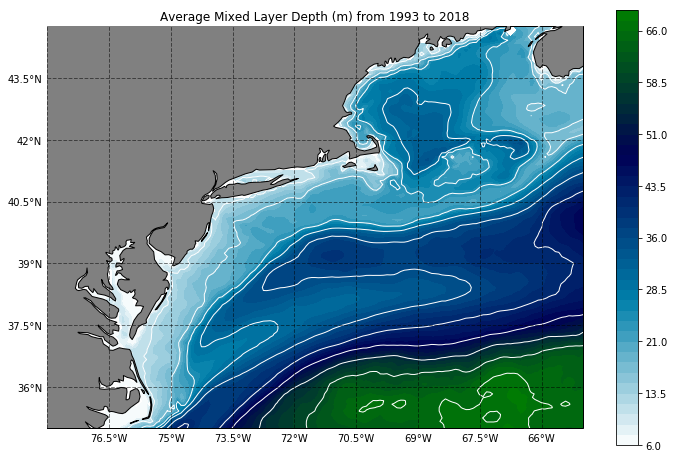

In [8]:
from matplotlib.pyplot import * ; import cartopy.feature as cfeature

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-78, -65, 35, 44.75], ccrs.PlateCarree())

feature = cfeature.NaturalEarthFeature(name='coastline', category='physical',scale='50m',edgecolor='black', facecolor='grey')
ax.add_feature(feature,zorder=5)

cf=ax.contourf(lon, lat, data_1993_2018_mld_mean, levels=60, transform=data_crs, cmap = 'ocean_r', cbar_kwargs={'label': DS.mlotst.units})
ax.contour(lon, lat, data_1993_2018_mld_mean, levels=10, linestyle='--', linewidths=1,colors='white',zorder=5,)
plt.colorbar(cf)
ax.set_label(DS.mlotst.units)
plt.title("Average Mixed Layer Depth (m) from 1993 to 2018")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=0.5, linestyle='--', zorder = 20)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.show()

### Create a time series line plot of annual average MLD weighted by latitude (entire region)

In [9]:
def weighted_mean(data_da, dim, weights):
    r"""Computes the weighted mean.
    We can only do the actual weighted mean over the dimensions that
    ``data_da`` and ``weights`` share, so for dimensions in ``dim`` that aren't
    included in ``weights`` we must take the unweighted mean.

    This functions skips NaNs, i.e. Data points that are NaN have corresponding
    NaN weights.

    Args:
        data_da (xarray.DataArray):
            Data to compute a weighted mean for.
        dim (str | list[str]):
            dimension(s) of the dataarray to reduce over
        weights (xarray.DataArray):
            a 1-D dataarray the same length as the weighted dim, with dimension
            name equal to that of the weighted dim. Must be nonnegative.
    Returns:
        (xarray.DataArray):
            The mean over the given dimension. So it will contain all
            dimensions of the input that are not in ``dim``.
    Raises:
        (IndexError):
            If ``weights.dims`` is not a subset of ``dim``.
        (ValueError):
            If ``weights`` has values that are negative or infinite.
    """
    if isinstance(dim, str):
        dim = [dim]
    else:
        dim = list(dim)

    if not set(weights.dims) <= set(dim):
        dim_err_msg = (
            "`weights.dims` must be a subset of `dim`. {} are dimensions in "
            "`weights`, but not in `dim`."
        ).format(set(weights.dims) - set(dim))
        raise IndexError(dim_err_msg)
    else:
        pass  # `weights.dims` is a subset of `dim`

    if (weights < 0).any() or xr.ufuncs.isinf(weights).any():
        negative_weight_err_msg = "Weight must be nonnegative and finite"
        raise ValueError(negative_weight_err_msg)
    else:
        pass  # `weights` are nonnegative

    weight_dims = [
        weight_dim for weight_dim in dim if weight_dim in weights.dims
    ]

    if np.isnan(data_da).any():
        expanded_weights, _ = xr.broadcast(weights, data_da)
        weights_with_nans = expanded_weights.where(~np.isnan(data_da))
    else:
        weights_with_nans = weights

    mean_da = ((data_da * weights_with_nans).sum(weight_dims, skipna=True)
               / weights_with_nans.sum(weight_dims))
    other_dims = list(set(dim) - set(weight_dims))
    return mean_da.mean(other_dims, skipna=True)

In [10]:
rad  = 4.*math.atan(1.)/180.
weights_lat   = np.cos(lat*rad)

In [312]:
wmean_lat = weighted_mean(data_1993_2018.mlotst, dim='latitude', weights=weights_lat)
wmean =  wmean_lat.mean(dim='longitude')
annual_wmean = wmean.groupby('time.year').mean(dim='time')

/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [314]:
print(data_1993_2018.mlotst.shape)

(9490, 133, 181)


In [16]:
print(wmean_lat.shape)
print(wmean.shape)
print(annual_wmean.shape)

(9490, 181)
(9490,)
(26,)


In [188]:
monthly_wmean = wmean.groupby('time.month').mean(dim='time')

/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


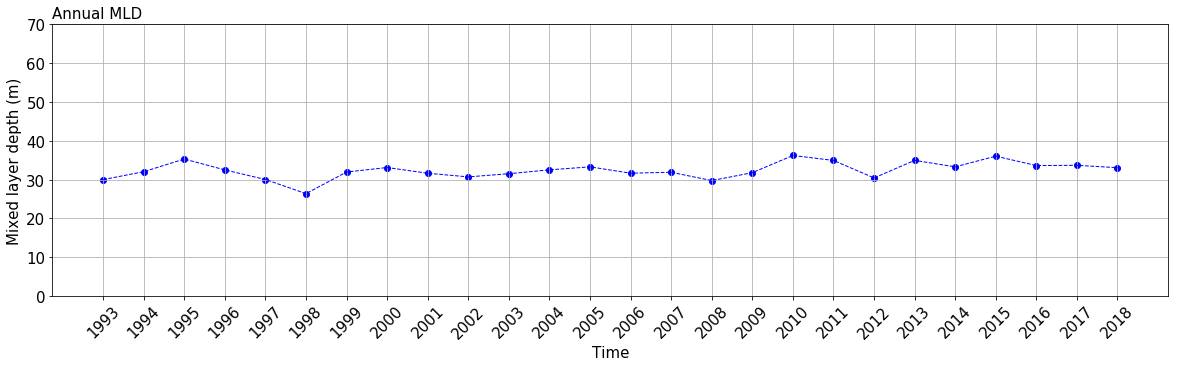

In [18]:
plt.figure(figsize=(20,5))
plt.ylim(0,70)
plt.scatter(annual_wmean.year, annual_wmean.data, marker='o', c='blue')
plt.plot(annual_wmean.year, annual_wmean.data, linestyle='--', color='blue', linewidth=1)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Mixed layer depth (m)', fontsize = 15)
plt.title('Annual MLD', loc='left',fontsize = 15)
plt.xticks([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
           2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], fontsize = 15, rotation = 45) 
# plt.yticks([26, 28, 30, 32, 34, 36], fontsize = 15) 
plt.yticks([0,10,20,30,40,50,60,70], fontsize = 15) 
plt.grid(True)
plt.show()

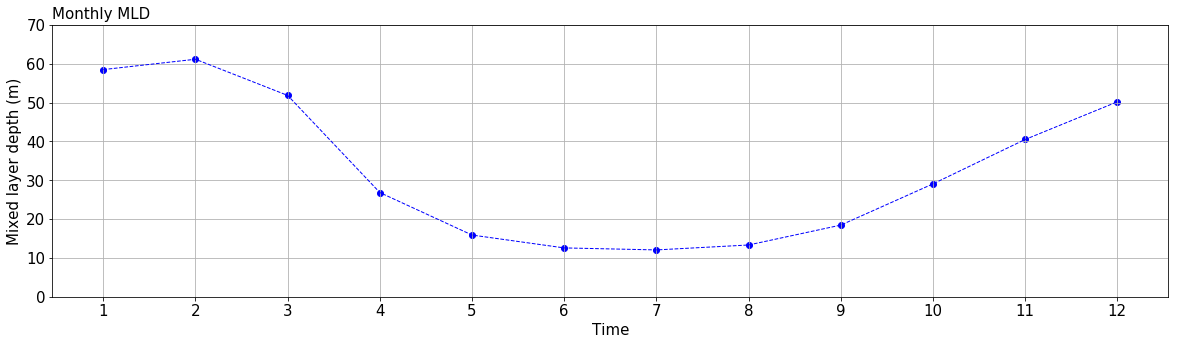

In [19]:
plt.figure(figsize=(20,5))
plt.ylim(0,70)
plt.scatter(monthly_wmean.month, monthly_wmean.data, marker='o', c='blue')
plt.plot(monthly_wmean.month, monthly_wmean.data, linestyle='--', color='blue', linewidth=1)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Mixed layer depth (m)', fontsize = 15)
plt.title('Monthly MLD', loc='left',fontsize = 15)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], fontsize = 15) 
plt.yticks([0,10,20,30,40,50,60,70], fontsize = 15) 
plt.grid(True)
plt.show()

### Create a spatial plots of annual average MLD weighted by latitude by season
To accomplish this, first let's resample dataset into seasons. This offset aliases reference discusses all about the different time frequencies that we can resample the dataset. Since we want to resample the dataset by seasons, where DJF season belongs to the succeeding year, we use the Q-FEB offset alias. Q means quarterly, and FEB means it ends in Feb.

In [20]:
wmean_seasonal = data_1993_2018.resample(time='Q-FEB').mean()

In [26]:
# print(wmean_seasonal.time)
wmean_DJF = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==2) # 2 for FEB
wmean_MAM = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==5) # 5 for MAY
wmean_JJA = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==8) # 8 for AUG
wmean_SON = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==11) # 11 for SEP

In [27]:
print(wmean_DJF['mlotst'].shape)
wmean_DJF_mld_mean=wmean_DJF.mlotst.mean(dim='time')
print(wmean_DJF_mld_mean.shape)

(27, 133, 181)
(133, 181)


/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [23]:
print(wmean_MAM['mlotst'].shape)
wmean_MAM_mld_mean=wmean_MAM.mlotst.mean(dim='time')
print(wmean_MAM_mld_mean.shape)

(26, 133, 181)
(133, 181)


In [24]:
print(wmean_JJA['mlotst'].shape)
wmean_JJA_mld_mean=wmean_JJA.mlotst.mean(dim='time')
print(wmean_JJA_mld_mean.shape)

(26, 133, 181)
(133, 181)


In [25]:
print(wmean_SON['mlotst'].shape)
wmean_SON_mld_mean=wmean_SON.mlotst.mean(dim='time')
print(wmean_SON_mld_mean.shape)

(26, 133, 181)
(133, 181)


/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


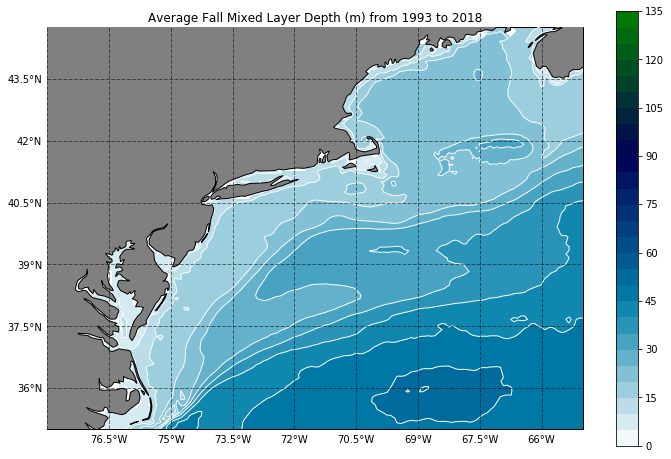

In [26]:
from matplotlib.pyplot import * ; import cartopy.feature as cfeature

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-78, -65, 35, 44.75], ccrs.PlateCarree())

feature = cfeature.NaturalEarthFeature(name='coastline', category='physical',scale='50m',edgecolor='black', facecolor='grey')
ax.add_feature(feature,zorder=5)

cf=ax.contourf(wmean_SON['longitude'], wmean_SON['latitude'], wmean_SON_mld_mean, np.arange(0,140,5),cmap = 'ocean_r')
ax.contour(wmean_SON['longitude'], wmean_SON['latitude'], wmean_SON_mld_mean, levels=10, linestyle='--', linewidths=1,colors='white',zorder=5,)
plt.colorbar(cf)
# ax.set_label(DS.mlotst.units)
plt.title("Average Fall Mixed Layer Depth (m) from 1993 to 2018")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=0.5, linestyle='--', zorder = 20)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.savefig('glorys.png')
plt.show()

### Create time series of annual average MLD weighted by latitude by season

In [28]:
wmean_DJF = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==2) # 2 for FEB
wmean_MAM = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==5) # 5 for MAY
wmean_JJA = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==8) # 8 for AUG
wmean_SON = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==11) # 11 for SEP

In [29]:
print(wmean_DJF['mlotst'].shape)
wmean_DJF_mld_mean=wmean_DJF.mlotst.mean(dim='time')
print(wmean_DJF_mld_mean.shape)

(27, 133, 181)
(133, 181)


/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [30]:
wmean_DJF_lat = weighted_mean(wmean_DJF.mlotst, dim='latitude', weights=weights_lat)
wmean_DJF =  wmean_DJF_lat.mean(dim='longitude')

In [32]:
wmean_MAM_lat = weighted_mean(wmean_MAM.mlotst, dim='latitude', weights=weights_lat)
wmean_MAM =  wmean_MAM_lat.mean(dim='longitude')

In [33]:
wmean_JJA_lat = weighted_mean(wmean_JJA.mlotst, dim='latitude', weights=weights_lat)
wmean_JJA =  wmean_JJA_lat.mean(dim='longitude')

In [34]:
wmean_SON_lat = weighted_mean(wmean_SON.mlotst, dim='latitude', weights=weights_lat)
wmean_SON =  wmean_SON_lat.mean(dim='longitude')

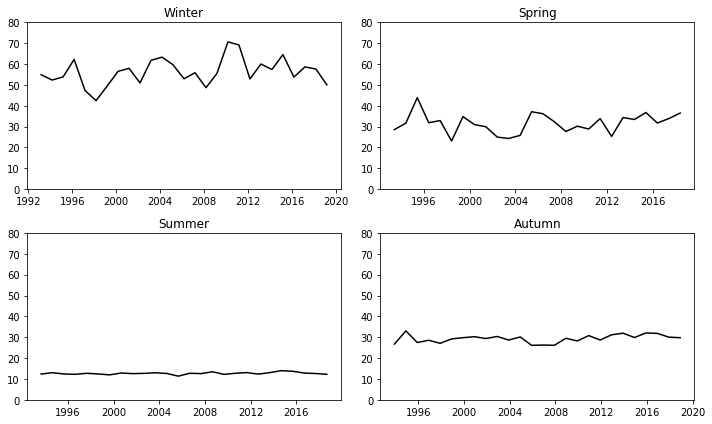

In [35]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

# winter
ax1.plot(wmean_DJF['time'], wmean_DJF.data, color='k')
ax1.set_title('Winter')
# # spring
ax2.plot(wmean_MAM['time'], wmean_MAM.data, color='k')
ax2.set_title('Spring')
# # summer
ax3.plot(wmean_JJA['time'], wmean_JJA.data, color='k')
ax3.set_title('Summer')
# # autumn
ax4.plot(wmean_SON['time'], wmean_SON.data, color='k')
ax4.set_title('Autumn')

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim((0,80))
    
plt.tight_layout()

# MASKING

In [1098]:
DS=xr.open_dataset(fname)

In [1099]:
print(DS)

<xarray.Dataset>
Dimensions:    (latitude: 133, longitude: 181, time: 9490)
Coordinates:
  * latitude   (latitude) float32 35.0 35.083332 35.166668 ... 45.916668 46.0
  * time       (time) datetime64[ns] 1993-01-01T12:00:00 ... 2018-12-25T12:00:00
  * longitude  (longitude) float32 -78.0 -77.916664 ... -63.083332 -63.0
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
Attributes:
    title:                              daily mean fields from Global Ocean P...
    easting:                            longitude
    northing:                           latitude
    history:                            2019/04/04 11:59:50 MERCATOR OCEAN Ne...
    source:                             MERCATOR GLORYS12V1
    institution:                        MERCATOR OCEAN
    references:                         http://www.mercator-ocean.fr
    comment:                            CMEMS product
    Conventions:                        CF-1.4
    domain_name:                        GL12
    F

In [1117]:
print(DS['mlotst'].shape)
DS_lat = DS['latitude']; DS_lon = DS['longitude']
print(len(DS_lat));print(len(DS_lon))

(9490, 133, 181)
133
181


In [1101]:
latcheck = []; loncheck = []
for ii in range(len(DS_lon)):
    for i in range(len(DS_lat)):
#         print(ii, i, 'point', DS_lon[ii].data, DS_lat[i].data)
        latcheck.append(DS_lat[i].data)
        loncheck.append(DS_lon[ii].data)

In [1102]:
newdf = pd.DataFrame({'lon': loncheck,'lat': latcheck}) 

In [1103]:
newlon = [-69.5,-68,-67.5, -67, -66.5, -66, -65.7, -66,-66, -66.5, -67,
         -68, -69, -70,-70.5, -70.5,-69.5, -72, -74, -74.25, -76, -75.5, -75, -74.75, -74.5, -72, -71.4, -69.5]
newlat = [40,40.3,40.4, 40.6, 40.8, 41.45, 41.8, 42.1, 43, 44.2, 44.2, 44.2, 43.9, 43.7,
         43, 42.2, 41, 41, 40.5, 39.4, 37, 36, 35.5, 36, 37.4, 39.5, 40, 40]

In [1104]:
from matplotlib.path import Path

newlon = newlon 
newlat = newlat 
newpath = list(zip(newlon,newlat))
newpd = pd.DataFrame(newpath, columns=['lon','lat'])
path_new = Path(newpath)

In [1105]:
points = np.vstack((loncheck,latcheck)).T

In [1106]:
path_new = Path(newpath)
        
grid = path_new.contains_points(points)
grid = grid.reshape((181,133))

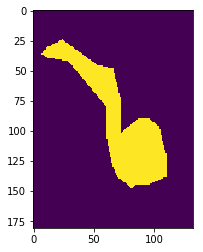

In [1107]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(grid)

In [1086]:
print(grid.shape)

(181, 133)


In [299]:
wmean_DJF = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==2) # 2 for FEB
wmean_MAM = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==5) # 5 for MAY
wmean_JJA = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==8) # 8 for AUG
wmean_SON = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==11) # 11 for SEP

In [308]:
mean = []
std = []
for i in range(26):
    wmean = wmean_SON['mlotst']
    useable = wmean[i]
    useabletransp = useable.transpose()
    
    newlon = lonlist_v #newlon 
    newlat = latlist_v #newlat 
    newpath = list(zip(newlon,newlat))
    newpd = pd.DataFrame(newpath, columns=['lon','lat'])
    path_new = Path(newpath)
    points = np.vstack((loncheck,latcheck)).T
    path_new = Path(newpath)
        
    grid = path_new.contains_points(points)
    grid = grid.reshape((181,133))
    
    newgridded = np.where(grid == False, np.nan, useabletransp)
    
    mean.append(np.nanmean(newgridded))
    std.append(np.nanstd(newgridded))

In [309]:
print(mean)
print(std)

[14.786698, 16.851925, 18.511106, 15.156162, 15.450435, 15.453477, 17.784977, 18.884493, 18.150478, 17.409363, 15.31084, 16.73281, 13.901999, 16.595701, 16.179913, 17.033484, 16.835405, 16.513866, 17.506998, 19.817364, 18.05147, 19.406366, 19.032963, 18.288914, 16.643837, 16.155764]
[2.6097157, 3.3188477, 3.9057636, 1.7692235, 3.507276, 1.9207516, 4.05878, 3.51871, 5.295547, 3.9704456, 2.8393028, 3.926728, 2.5660105, 2.7434046, 2.2295928, 3.8738148, 4.2402496, 3.1440036, 3.019082, 3.5364394, 3.899513, 5.5749135, 4.487034, 4.2926793, 2.8346868, 2.4267008]


In [271]:
print(len(mean))

26


In [265]:
years = []
for year in range(1993, 2020):
#     print(year)
    years.append(year)
print(years)

[1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [251]:
print(len(years))

27


### Southern Mid Atlantic Bight

In [296]:
v = open("bndmbs.txt", "r", encoding="utf-8")
v.read()
v = '  37.00   76.00\n  36.00   75.50\n  35.50   75.00\n  36.00   74.75\n  37.40   74.50\n  39.50   72.00\n  40.50   74.00\n  39.40   74.25\n  37.00   76.00\n'
output1v = v.split('\n')

newv = [] 
for string in output1v:
    output2v = string.split(' ')
    newv.append(output2v)

newv = [['', '', '37.00', '', '', '76.00'], ['', '', '36.00', '', '', '75.50'], ['', '', '35.50', '', '', '75.00'], ['', '', '36.00', '', '', '74.75'], ['', '', '37.40', '', '', '74.50'], ['', '', '39.50', '', '', '72.00'], ['', '', '40.50', '', '', '74.00'], ['', '', '39.40', '', '', '74.25'], ['', '', '37.00', '', '', '76.00']]
lon_v = []; lat_v = []

for i in range(9): 
    v1 = newv[i][2]
    lat_v.append(v1)
    v3 = newv[i][5]
    lon_v.append(v3)
lonlist_v = [float(i)*-1 for i in lon_v]; latlist_v = [float(i) for i in lat_v]
df_v = pd.DataFrame({'lon': lonlist_v, 'lat': latlist_v,})

lonlist_v_plot = [float(i)*-1 for i in lon_v]; latlist_v = [float(i) for i in lat_v]
df_v_plot = pd.DataFrame({'lon': lonlist_v_plot, 'lat': latlist_v,})
x_v = df_v_plot['lon']; y_v = df_v_plot['lat']


lonlist_vneg = [float(i)*-1 for i in lon_v]
df_v_plottable = pd.DataFrame({'lon': lonlist_vneg, 'lat': latlist_v,})

In [297]:
polygon_v = Polygon(df_v.values.tolist())
print(polygon_v)

POLYGON ((-76 37, -75.5 36, -75 35.5, -74.75 36, -74.5 37.4, -72 39.5, -74 40.5, -74.25 39.4, -76 37))


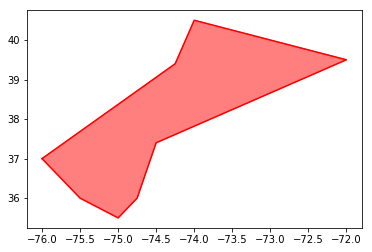

In [298]:
plt.fill(x_v,y_v,color='red',alpha=0.5)
plot(x_v,y_v,color='red') 

In [825]:
# NEFSC dataset
# winter
winter_mean_NEFSC = [26.057692307692307, 28.333333333333332, 36.84782608695652, 40.5735294117647, 34.5, 34.0, 31.239436619718308, 28.54237288135593, 35.38333333333333, 28.78787878787879, 48.093333333333334, 36.74757281553398, 33.00934579439252, 42.90277777777778, 57.50684931506849, 34.411764705882355, 25.513157894736842, 42.18518518518518, 35.81818181818182, 29.677419354838708, 40.46341463414634, 39.13333333333333, 34.865671641791046, 33.36734693877551, 41.59375]
winter_std_NEFSC = [13.450582699730617, 9.114091653404998, 19.686393937950985, 23.893617568121815, 25.83525338486769, 21.251890672193312, 19.23795711513524, 11.09259155363631, 20.815648991512447, 13.165824233177645, 40.49897340485123, 18.646199448009238, 23.407181339222003, 36.327989334350484, 47.38029457006808, 15.484450837367632, 12.898055068939794, 24.73453378674498, 16.30419082560681, 24.19441352234253, 65.53285342520026, 37.20874084781997, 29.58649134952294, 30.067766432365616, 25.382060435186972]
winter_year_NEFSC = [1988, 1990, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2017]
winter_ratiomean_NEFSC = [62.05919836817093, 50.91204606789237, 69.87078259530796, 77.02300160361332, 59.079926977343156, 67.11617916162173, 52.639896442454194, 55.34881337115729, 62.53512130880484, 55.46022595244665, 63.217676780309716, 54.149150484128725, 55.615673655303446, 55.45443932462787, 67.55490370536626, 52.71052523930635, 43.40947132929468, 58.47488673331783, 72.68117218104724, 53.45436397722917, 70.82367122814048, 57.778291714759256, 50.24611473123461, 67.23295313416723, 79.50353958503639]
winter_ratiostd_NEFSC = [27.49752194073627, 18.49729857101814, 28.498653638071758, 22.304564224794003, 27.942897531870315, 25.27969642131353, 29.008754760071337, 28.91884570748634, 30.694254855714888, 28.868820429676855, 26.677632459108068, 30.06705747415187, 32.093924084773676, 28.684471117427933, 27.39612457684082, 29.54595720325395, 27.27728613085481, 26.203341162882253, 21.592651249529528, 30.70579994748364, 19.720468011209523, 31.345687884141732, 31.20965199503037, 26.647560729327296, 20.493752058814778]

# spring
spring_mean_NEFSC = [10.318471337579618, 8.705882352941176, 30.655172413793103, 22.27848101265823, 22.93103448275862, 27.011363636363637, 32.78260869565217, 24.962264150943398, 19.472727272727273, 21.524475524475523, 25.2, 22.6, 16.798561151079138, 24.907692307692308, 18.901408450704224, 20.714285714285715, 24.237037037037037, 20.102272727272727, 29.785714285714285, 27.662921348314608, 20.244318181818183, 16.258706467661693, 23.71794871794872, 26.483516483516482, 28.0, 31.614173228346456, 19.42142857142857, 24.401459854014597, 24.595744680851062, 20.75968992248062, 20.32]
spring_std_NEFSC = [7.620012632535889, 2.229481606852615, 47.889608424250746, 16.06791412504321, 18.760295222207418, 20.999996890082866, 37.234340806112044, 14.82014364579307, 10.065573164800234, 19.258739434795686, 24.075179868783653, 30.95945282620876, 15.528459079798374, 19.987378247456995, 16.14590167333712, 22.898502229585965, 32.68534004476474, 14.390322237034319, 35.177972215933984, 33.2971961078027, 21.189551915734565, 15.816849759620528, 19.934308561496024, 40.16033494696605, 22.21565559544335, 29.257219226891483, 15.860029782667226, 25.034523178889035, 22.062890214567556, 15.718607203028542, 15.675952407141574]
spring_year_NEFSC = [1987, 1988, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
spring_ratiomean_NEFSC = [24.408851259491737, 27.526054657566302, 59.28751603593223, 53.195064498404676, 51.5219907157868, 63.296455341994964, 54.933250276665845, 59.71837759384309, 57.33369224981981, 48.15609336118207, 61.33851190126099, 45.89050307126219, 41.830304205665065, 53.63696167577161, 46.60413624648873, 43.927487395049084, 52.83503754073961, 50.64454518309389, 48.28416741829307, 60.59581552575717, 36.930050413165034, 33.30346615016252, 43.10398605497094, 38.66495542620532, 52.68202275993941, 50.30500180790444, 38.892128981481726, 46.78298826174094, 43.95968027167322, 41.658991612689896, 38.78026348635025]
spring_ratiostd_NEFSC = [13.551446460263902, 12.719478516624486, 27.474228797125782, 29.558455254657588, 31.1474218370493, 30.222266957944576, 30.523630458018374, 28.864485305235867, 26.793497753176354, 30.182192505160526, 25.367042405722007, 30.8556056833145, 28.117787676700583, 27.830315723187553, 25.585332632689166, 30.4959833860115, 28.345922380421744, 26.195965715508247, 30.029879484492245, 26.87540953881496, 29.298303359881366, 29.53634076763347, 34.65158893059031, 27.96763209047904, 27.831169553568657, 33.55611574006671, 28.676906833040256, 32.385454005298854, 27.393059047229336, 29.885080849410766, 27.620234150321433]

# summer
summer_mean_NEFSC = [6.7368421052631575, 10.11111111111111, 8.557692307692308, 9.340425531914894, 8.25, 10.479166666666666, 8.553030303030303, 7.622641509433962, 8.122699386503067, 8.869565217391305, 8.170212765957446, 8.806451612903226, 9.395348837209303, 7.849056603773585, 10.566265060240964, 7.090909090909091, 9.316176470588236, 6.253333333333333, 7.903448275862069, 9.972972972972974, 7.802030456852792, 8.655172413793103, 8.438202247191011, 8.931818181818182, 8.854014598540147, 6.6, 8.380952380952381, 8.767857142857142, 7.8, 7.2439024390243905, 7.470588235294118]
summer_std_NEFSC = [1.4079972089286532, 4.671723450719231, 3.757556489160312, 6.783216486442302, 2.735383562194383, 2.534775858430538, 2.9169533251947644, 2.596050366157877, 2.516054637709184, 4.845844966436212, 2.352788807168598, 2.7629795610893244, 2.7872117393870863, 1.9845191862465206, 4.199862863859693, 1.6247247889198464, 3.5038649683992675, 0.7727335356493318, 2.7241821859735222, 3.234640515250383, 2.5607707583106043, 2.6738783045244032, 2.903583429378004, 3.564819979157931, 2.989048997850323, 0.8944271909999159, 2.1089378956287566, 2.381680624559598, 1.6431676725154982, 1.6090445581909478, 2.946341276264689]
summer_year_NEFSC = [1982, 1987, 1989, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
summer_ratiomean_NEFSC = [8.29008362068762, 30.570319633050158, 35.0634304786899, 14.51553211633688, 20.01136745950336, 17.479200359732054, 22.074556520863446, 11.049168240865564, 14.662191792652674, 30.80797172226786, 13.294082931729474, 17.197301509493645, 16.943416961345342, 12.810256164451511, 23.200746641671408, 12.15926793494031, 18.11094152195028, 11.086515152861944, 18.507988526603768, 21.128724366566075, 20.92045074009829, 16.289963250253333, 13.85674072380008, 21.57572320316983, 18.334342539337896, 11.53647272551186, 26.632455083743555, 20.559722609077042, 11.846942835346379, 19.755087562739863, 19.207849398826912]
summer_ratiostd_NEFSC = [4.757300935907216, 17.316331264366863, 18.95377084265627, 9.930441222202663, 10.303015567523413, 6.339592822470576, 9.50841476066093, 7.296341628217712, 5.373682889398619, 21.654574606770378, 6.424924084048472, 8.403638495235759, 5.654152859655094, 4.132656008709163, 14.362707547139875, 3.8986238256438357, 14.160005973030254, 2.8044732018555982, 10.937382469992546, 14.17777085573149, 10.411670361067971, 12.604434016130565, 11.890524368007831, 12.272103321944979, 11.63652731329347, 3.713921673002934, 9.351309456361822, 12.025971760655771, 5.148692829529731, 11.332857586366039, 11.340609621152645]

# fall
fall_mean_NEFSC = [21.57777777777778, 21.142857142857142, 12.609756097560975, 13.160714285714286, 11.448717948717949, 12.48314606741573, 17.46031746031746, 12.595505617977528, 12.142857142857142, 16.491666666666667, 20.61061946902655, 17.61946902654867, 16.074380165289256, 19.330708661417322, 14.848837209302326, 17.319327731092436, 17.496402877697843, 17.754901960784313, 16.73015873015873, 16.803418803418804, 20.321678321678323, 17.762237762237763, 16.326241134751772, 17.89189189189189, 16.88617886178862, 20.973509933774835, 14.885245901639344, 11.477777777777778, 25.818181818181817, 14.525925925925925, 17.81021897810219]
fall_std_NEFSC = [17.81787775456908, 7.794052395721544, 4.702917659036612, 6.927617419927512, 4.6224956319574675, 5.261594036788406, 8.251735686089159, 5.087236928922301, 4.641725004294258, 7.887865197057235, 11.093300446278523, 13.543131221655445, 8.750395504638822, 12.332081737079257, 6.935870006686833, 12.166871367210979, 10.973204584395852, 9.727409752104753, 8.434607470096234, 12.605581218896457, 14.87535129120114, 9.503118866803263, 12.742783085731709, 13.437249037750208, 9.274681959137794, 13.934105410762257, 9.371309055308497, 4.894913153624189, 10.524430453171153, 9.015599771962119, 11.989905586830439]
fall_year_NEFSC = [1987, 1988, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
fall_ratiomean_NEFSC = [47.42656393371849, 78.97565514514348, 41.04000359212208, 37.06786932954339, 33.31291690384675, 37.21457177975248, 57.2447989082318, 39.3468282580268, 37.07933387746551, 45.308953364317055, 50.411413986232326, 45.80115268372334, 46.04125473696033, 44.96128040266335, 42.55653492039325, 46.354452059675594, 37.14866544740365, 47.3816142720115, 48.25668831535305, 42.30701285817888, 44.0748916535259, 41.01977715316326, 34.59315320512345, 39.37157650430072, 38.6890554105631, 45.67781683757526, 32.70539908972667, 27.900817479037336, 81.4221945233352, 31.700384592755803, 40.78944434738668]
fall_ratiostd_NEFSC = [24.932912936999376, 9.241859888894385, 22.766590168748284, 29.565916136062103, 19.281508498149154, 24.92934849811239, 28.916872665839566, 26.869415695902788, 21.791562710281788, 24.48416724027297, 23.48866840723075, 27.818319452684513, 27.23963327390856, 26.81107192692694, 26.284997871064547, 25.44569002424885, 23.396870575893946, 29.55725668989327, 28.714665909684346, 29.084882756169954, 31.09010540189961, 27.549863675706813, 28.130959926012427, 26.89863564153973, 27.597877269235127, 31.609077451774702, 22.56792546164879, 22.249062500760573, 9.650707532316547, 25.702473133745034, 28.91129514498135]

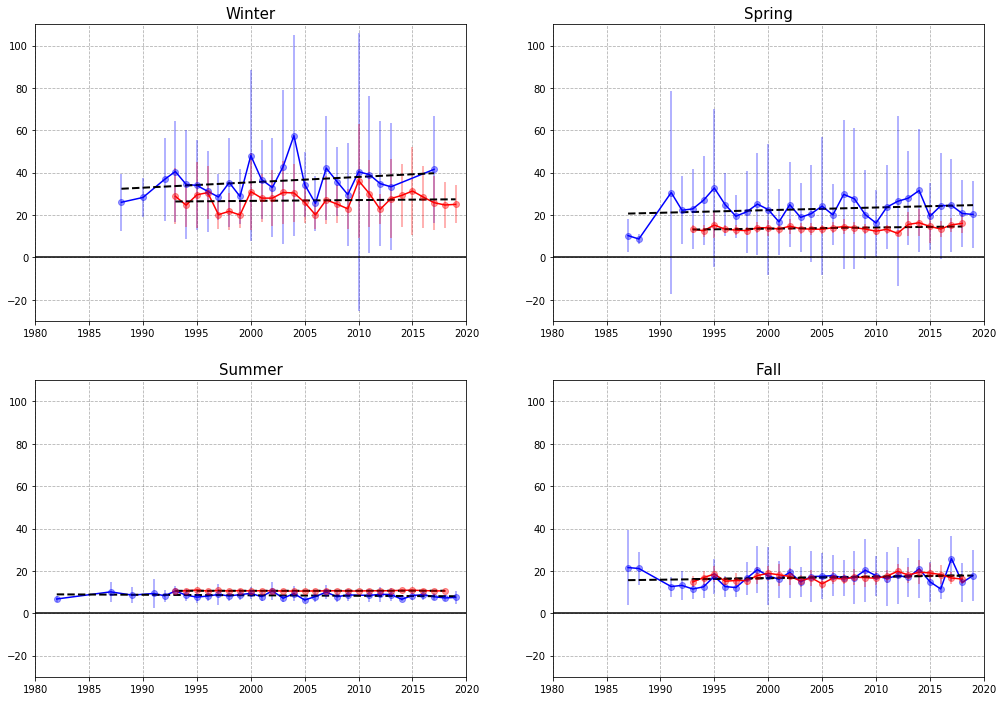

In [826]:
# Southern MAB
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(17,12))

# winter
winter_mean = [28.89859, 24.681742, 29.569609, 30.632637, 20.217638, 21.789711, 20.032, 31.115738, 28.02335, 27.998352, 30.681995, 30.44726, 25.967125, 20.105131, 27.190958, 25.205345, 22.945515, 36.24775, 30.155748, 22.715542, 27.79544, 29.283785, 31.382925, 28.502289, 25.871773, 24.775734, 25.064354]
winter_std = [13.151683, 10.3551, 15.584091, 12.546687, 6.5617204, 8.637526, 6.3076563, 18.147623, 11.38287, 13.143335, 14.90781, 13.527501, 9.80529, 6.495036, 11.180669, 9.108644, 9.607383, 26.94969, 15.677735, 7.079243, 18.655209, 15.031347, 20.689566, 14.659563, 12.681555, 10.6778965, 8.983416]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,2019]
ax1.axhline(y=0, color='black', linestyle='-')
ax1.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax1.plot(winter_year_NEFSC, winter_mean_NEFSC, color='blue')
ax1.errorbar(winter_year_NEFSC, winter_mean_NEFSC, winter_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax1.plot(np.unique(winter_year_NEFSC), np.poly1d(np.polyfit(winter_year_NEFSC, winter_mean_NEFSC, 1))(np.unique(winter_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')
ax1.plot(years, winter_mean, color='red')
ax1.errorbar(years, winter_mean, winter_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax1.plot(np.unique(years), np.poly1d(np.polyfit(years, winter_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax1.set_title('Winter',fontsize = 15)

# spring
spring_mean = [13.356343, 12.589188, 15.303302, 13.318162, 12.913619, 12.639998, 14.060595, 13.9939, 13.410723, 14.762077, 13.608124, 13.343668, 13.314746, 14.043632, 14.55661, 14.055724, 13.388602, 12.412607, 13.316013, 11.375993, 15.606524, 16.393677, 14.655803, 13.433977, 15.3618355, 16.0873]
spring_std = [1.8582764, 2.919318, 6.305127, 2.0084407, 2.2118556, 1.9187373, 2.6177857, 3.7761269, 2.3714619, 3.5937963, 2.7617066, 2.7028534, 2.1863937, 2.6373916, 3.506935, 2.8477583, 2.3046257, 1.8548256, 2.0159245, 1.0721481, 5.675323, 6.2476172, 7.7501473, 3.6110764, 3.3136458, 4.466437]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax2.grid(True)
ax2.axhline(y=0, color='black', linestyle='-')
ax2.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax2.plot(spring_year_NEFSC, spring_mean_NEFSC, color='blue')
ax2.errorbar(spring_year_NEFSC, spring_mean_NEFSC, spring_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax2.plot(np.unique(spring_year_NEFSC), np.poly1d(np.polyfit(spring_year_NEFSC, spring_mean_NEFSC, 1))(np.unique(spring_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax2.plot(years, spring_mean, color='red')
ax2.errorbar(years, spring_mean, spring_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax2.plot(np.unique(years), np.poly1d(np.polyfit(years, spring_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax2.set_title('Spring',fontsize = 15)

# summer
summer_mean = [10.50372, 10.645221, 10.945653, 10.51267, 10.758167, 10.53024, 10.693056, 10.562223, 10.645427, 10.643091, 10.498914, 10.491995, 10.491645, 10.544239, 10.574412, 10.634314, 10.492299, 10.521432, 10.613982, 10.618012, 10.64785, 10.827015, 10.891957, 10.700449, 10.572921, 10.549558]
summer_std = [0.38553232, 0.48558757, 0.50024325, 0.39243162, 0.44498953, 0.39493218, 0.47619486, 0.43013066, 0.52530795, 0.5688693, 0.37671575, 0.37674686, 0.37513605, 0.3907404, 0.4568923, 0.5286771, 0.37650678, 0.39020512, 0.43975347, 0.49715823, 0.5123119, 0.56696284, 0.6195273, 0.694365, 0.4034982, 0.43162158] 
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax3.grid(True)
ax3.axhline(y=0, color='black', linestyle='-')
ax3.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax3.plot(summer_year_NEFSC, summer_mean_NEFSC, color='blue')
ax3.errorbar(summer_year_NEFSC, summer_mean_NEFSC, summer_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax3.plot(np.unique(summer_year_NEFSC), np.poly1d(np.polyfit(summer_year_NEFSC, summer_mean_NEFSC, 1))(np.unique(summer_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax3.plot(years, summer_mean, color='red')
ax3.errorbar(years, summer_mean, summer_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax3.plot(np.unique(years), np.poly1d(np.polyfit(years, summer_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax3.set_title('Summer',fontsize = 15)

# autumn
fall_mean = [14.786698, 16.851925, 18.511106, 15.156162, 15.450435, 15.453477, 17.784977, 18.884493, 18.150478, 17.409363, 15.31084, 16.73281, 13.901999, 16.595701, 16.179913, 17.033484, 16.835405, 16.513866, 17.506998, 19.817364, 18.05147, 19.406366, 19.032963, 18.288914, 16.643837, 16.155764]
fall_std = [2.6097157, 3.3188477, 3.9057636, 1.7692235, 3.507276, 1.9207516, 4.05878, 3.51871, 5.295547, 3.9704456, 2.8393028, 3.926728, 2.5660105, 2.7434046, 2.2295928, 3.8738148, 4.2402496, 3.1440036, 3.019082, 3.5364394, 3.899513, 5.5749135, 4.487034, 4.2926793, 2.8346868, 2.4267008]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax4.grid(True)
ax4.axhline(y=0, color='black', linestyle='-')
ax4.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax4.plot(fall_year_NEFSC, fall_mean_NEFSC, color='blue')
ax4.errorbar(fall_year_NEFSC, fall_mean_NEFSC, fall_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax4.plot(np.unique(fall_year_NEFSC), np.poly1d(np.polyfit(fall_year_NEFSC, fall_mean_NEFSC, 1))(np.unique(fall_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax4.plot(years, fall_mean, color='red')
ax4.errorbar(years, fall_mean, fall_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax4.plot(np.unique(years), np.poly1d(np.polyfit(years, fall_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax4.set_title('Fall',fontsize = 15)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim((-30,110))
    ax.set_xlim((1980,2020))

plt.savefig('Southern Mid-Atlantic Bight')
    
# plt.tight_layout()

In [ ]:
m

In [832]:
import matplotlib.pyplot as plt; from scipy import stats

# winter
y = winter_mean
x = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# spring
y = spring_mean
x = years
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# summer
y = summer_mean
x = years
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# fall
y = fall_mean
x = years
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)

print('')

slope: 0.039607
p_value: 0.696166
R-squared: 0.006203

slope: 0.057270
p_value: 0.063217
R-squared: 0.136513

slope: 0.000983
p_value: 0.767854
R-squared: 0.003700

slope: 0.070709
p_value: 0.070773
R-squared: 0.129660



In [836]:
import matplotlib.pyplot as plt; from scipy import stats

# winter
y = winter_mean_NEFSC
x = winter_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# spring
y = spring_mean_NEFSC
x = spring_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# summer
y = summer_mean_NEFSC
x = summer_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# fall
y = fall_mean_NEFSC
x = fall_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)

slope: 0.253341
p_value: 0.184565
R-squared: 0.075233

slope: 0.124270
p_value: 0.252287
R-squared: 0.044935

slope: -0.024049
p_value: 0.228056
R-squared: 0.049692

slope: 0.068231
p_value: 0.308274
R-squared: 0.035760


### Northern Mid Atlantic Bight

In [278]:
x = open("bndmbn.txt", "r", encoding="utf-8")
x.read()
x = '  40.50   74.00\n  39.50   72.00\n  40.00   71.40\n  40.00   69.50\n  41.00   69.50\n  41.10   70.00\n  41.00   72.00\n  40.50   74.00\n'
output1x = x.split('\n')

newx = [] 
for string in output1x:
    output2x = string.split(' ')
    newx.append(output2x)
newx = [['', '', '40.50', '', '', '74.00'], ['', '', '39.50', '', '', '72.00'], ['', '', '40.00', '', '', '71.40'], ['', '', '40.00', '', '', '69.50'], ['', '', '41.00', '', '', '69.50'], ['', '', '41.10', '', '', '70.00'], ['', '', '41.00', '', '', '72.00'], ['', '', '40.50', '', '', '74.00']]
lon_x = []; lat_x = []

for i in range(8): 
    x1 = newx[i][2]
    lat_x.append(x1)
    x3 = newx[i][5]
    lon_x.append(x3)
lonlist_x = [float(i)*-1 for i in lon_x]; latlist_x = [float(i) for i in lat_x]
df_x = pd.DataFrame({'lon': lonlist_x, 'lat': latlist_x,})

lonlist_x_plot = [float(i)*-1 for i in lon_x]; latlist_x = [float(i) for i in lat_x]
df_x_plot = pd.DataFrame({'lon': lonlist_x_plot, 'lat': latlist_x,})
x_x = df_x_plot['lon']; y_x = df_x_plot['lat']

lonlist_xneg = [float(i)*-1 for i in lon_x]
df_x_plottable = pd.DataFrame({'lon': lonlist_xneg, 'lat': latlist_x,})

In [276]:
polygon_x = Polygon(df_x.values.tolist())
print(polygon_x)

POLYGON ((-74 40.5, -72 39.5, -71.40000000000001 40, -69.5 40, -69.5 41, -70 41.1, -72 41, -74 40.5))


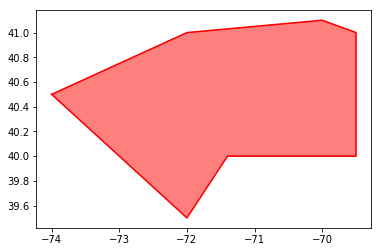

In [277]:
plt.fill(x_x,y_x,color='red',alpha=0.5)
plot(x_x,y_x,color='red') 

In [837]:
# NEFSC dataset
# winter
winter_mean_NEFSC = [34.0, 40.333333333333336, 33.68539325842696, 38.86363636363637, 38.59, 40.12931034482759, 33.95652173913044, 44.851063829787236, 30.53846153846154, 30.694444444444443, 43.15151515151515, 32.72222222222222, 21.92105263157895, 43.21951219512195, 40.59183673469388, 45.333333333333336, 48.425, 39.0, 41.19047619047619, 39.30555555555556, 39.54545454545455, 31.9375, 45.88235294117647, 33.44230769230769, 35.75, 36.875, 48.56521739130435]
winter_std_NEFSC = [14.721984992020035, 15.70687372945174, 17.742857401333218, 18.153991244878416, 17.778147407773545, 18.460076862816944, 14.510072346080534, 33.096682300170905, 20.677003204972948, 12.644184308424045, 16.351837075924397, 16.572974749980524, 16.69986499208637, 15.430468808832195, 15.934656108812717, 23.91898089507209, 20.649563849618886, 14.779866184930244, 19.93065795695115, 18.340929162386583, 13.978647910388093, 17.60487011065129, 11.787936067019647, 17.931693337292067, 17.966756741996786, 19.76231041764799, 19.37389548043853]
winter_year_NEFSC = [1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2017]
winter_ratiomean_NEFSC = [76.23306681646422, 89.0118981365219, 63.563542840327095, 70.4913565481966, 74.61951134294749, 67.80106591026636, 60.61574086236507, 65.65393269499219, 48.65770251617613, 52.63708242119741, 64.3746635392609, 48.53039757522891, 34.779315965100366, 60.47859989981051, 62.265164606578175, 56.049681493110505, 64.97502852927231, 53.61790297364032, 59.81631656100218, 58.86123397370342, 60.081617654394236, 56.335890230369145, 71.51924539698423, 63.17510471494319, 54.865809557269806, 65.8467026400928, 73.09590614223274]
winter_ratiostd_NEFSC = [15.96282438367346, 6.604521318130069, 27.724783491570438, 27.24082376697938, 21.66120313883902, 25.67198027269401, 26.444509500561143, 28.220726638623596, 33.75462209094246, 25.73263431671923, 30.47767890947114, 30.724468580526732, 27.163408325909817, 29.35602521533741, 31.577516552598915, 33.68715000940876, 22.267375005384434, 31.04880242192425, 28.670640728929776, 30.80917587894595, 30.427850808892863, 26.58126837578002, 23.298774668950397, 27.763498805019278, 30.485511173335787, 31.619615241906512, 25.142280322742174]

# spring
spring_mean_NEFSC = [5.0, 13.116279069767442, 8.375, 26.607843137254903, 38.55882352941177, 20.64, 21.22641509433962, 28.64, 32.07692307692308, 31.103448275862068, 31.833333333333332, 28.666666666666668, 17.635135135135137, 28.529411764705884, 29.31578947368421, 15.428571428571429, 26.25, 22.963414634146343, 29.571428571428573, 20.458823529411763, 23.053333333333335, 26.42105263157895, 17.539473684210527, 30.64179104477612, 21.80701754385965, 30.8125, 21.058252427184467, 24.039473684210527, 19.01298701298701, 21.613333333333333, 28.78048780487805, 19.941176470588236]
spring_std_NEFSC = [0, 6.920419240362559, 3.3354160160315836, 19.52135080507755, 21.96631230332482, 15.979272288096942, 15.784171123475328, 13.03482514906382, 21.67391687489479, 18.507172298794803, 24.086109952433013, 16.633299933166196, 11.413251519854494, 19.789542382493746, 24.73173967533261, 11.541591455831961, 20.93744651734463, 18.97005119964925, 13.212998650319062, 19.248100055389802, 17.07684803289936, 19.75062068755966, 15.085923495739273, 23.062301320512237, 19.281225691340293, 20.06018205937621, 13.250841810268275, 15.143263223381927, 16.0930628291669, 18.316211497020984, 18.187653110971592, 14.927675422497693]
spring_year_NEFSC = [1982, 1987, 1988, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
spring_ratiomean_NEFSC = [3.571428571428571, 42.93932630246024, 29.39818852250794, 59.05074771102793, 66.70543349309388, 48.598995464442666, 47.793973765023544, 59.15364222018222, 63.02290583014726, 67.29347318192262, 59.06422205104862, 59.25455864655319, 38.105624342764294, 57.19989115281585, 53.55233462158589, 36.673544545497485, 54.57096461867553, 44.066634602500855, 61.72621367478824, 39.05792518192078, 52.67780811213988, 43.13564407277732, 32.92920800742039, 51.66029498177808, 40.198220850783436, 53.97003234164474, 44.31043703449151, 44.653479267450535, 36.55757016185993, 37.31177479961987, 54.21550366944955, 42.74812851312627]
spring_ratiostd_NEFSC = [0, 24.87575397579526, 12.93256052631026, 31.45317974078662, 26.724109620123883, 28.73950436975683, 32.30343303036974, 25.0444158016482, 26.74768587571801, 23.106389287021102, 30.60271591499436, 26.220368634490836, 23.847158451463777, 26.130986316442968, 31.88116117046772, 22.997812181215203, 31.949987518736776, 29.26851294086835, 24.544890596780792, 30.778195782467392, 29.847669520933778, 30.20002031389174, 29.007110777489032, 32.276831196969056, 32.185302684021195, 26.265638220468762, 29.58391270130518, 31.68416823356412, 32.23248451107555, 27.997782771209078, 33.73799025115779, 31.868086478716716]

# summer
summer_mean_NEFSC = [9.0, 8.01923076923077, 7.641304347826087, 9.434782608695652, 9.029411764705882, 8.181818181818182, 8.081632653061224, 10.241379310344827, 9.064102564102564, 6.0, 8.3125, 10.363636363636363, 12.421052631578947, 7.235294117647059, 7.512820512820513, 7.111111111111111, 8.524590163934427, 8.75, 8.969696969696969, 9.692307692307692, 7.5, 9.533333333333333, 9.344827586206897, 9.93421052631579, 7.590361445783133, 7.852459016393443, 7.2, 20.0, 8.46875, 13.1, 9.458333333333334, 7.212121212121212]
summer_std_NEFSC = [0, 3.7337379925058682, 2.869243962674406, 3.1884177745612856, 2.822907314117809, 2.7539817690782895, 2.8272243064375995, 5.234877351638671, 13.253119940043858, 0.0, 2.6933310710093767, 7.486704211982513, 12.019963900267866, 1.855040827202527, 3.2352645289372757, 1.8751906221184675, 2.3707000188203846, 6.109051712050964, 3.594738449754658, 4.079175911058546, 3.5552123542372165, 5.400336689840399, 3.4874864266911034, 7.285301231595556, 2.2525657164194186, 3.166681046846843, 1.3038404810405297, 0, 2.5940637360455634, 5.8395205282625735, 3.5012937567439972, 1.8499590495058222]
summer_year_NEFSC = [1982, 1987, 1989, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
summer_ratiomean_NEFSC = [6.122448979591836, 31.82837093707801, 35.20179720866257, 17.067445239272118, 19.698026045536846, 15.246048008804406, 16.8713498420773, 17.249302809772242, 15.090827157788445, 16.34782608695652, 11.361931684612216, 19.78108290068821, 25.202349802138947, 13.836441290084217, 14.56984260935245, 12.773650401140713, 14.89032590278855, 14.49009179287616, 17.23294773780999, 18.993245607921285, 15.717518519242885, 18.295972065145776, 16.912254981101384, 20.32683207746701, 14.35004783147652, 14.708461393114414, 11.425879220961189, 12.195121951219512, 12.695104738254672, 29.301968794387605, 16.97612257932965, 13.04921379603215]
summer_ratiostd_NEFSC = [0, 17.19324047957339, 16.477228420516276, 7.207124204435687, 5.867480737583194, 6.3691562825027015, 6.117731771179673, 11.451505947011796, 10.79755037584715, 10.821808129463683, 4.117549957727322, 17.81839750883237, 25.913729874764297, 4.091755036168111, 11.29417564030816, 2.993322176576243, 6.098250361530334, 10.607731288239936, 12.62838613292879, 11.454708067860068, 13.727314173250937, 15.061920235998969, 10.556727396907474, 22.58627546424538, 10.699558297904995, 11.261807643237724, 1.743958036900585, 0, 5.615587866164289, 19.881997758489955, 8.027012621753157, 6.96040538551399]

# fall
fall_mean_NEFSC = [30.8125, 25.73076923076923, 32.90243902439025, 27.022222222222222, 21.52054794520548, 23.01492537313433, 20.380281690140844, 16.076190476190476, 23.0, 16.08, 17.87037037037037, 20.35135135135135, 24.15068493150685, 21.441558441558442, 15.780821917808218, 24.333333333333332, 17.25925925925926, 18.970588235294116, 20.25925925925926, 16.075949367088608, 19.45205479452055, 25.819148936170212, 27.55, 26.333333333333332, 19.068493150684933, 22.658227848101266, 25.83076923076923, 28.074626865671643, 23.901408450704224, 25.55223880597015, 33.30769230769231, 23.880597014925375, 23.444444444444443]
fall_std_NEFSC = [21.95807956230499, 12.081581659063326, 13.525540429219049, 15.368931010452236, 12.69635729587329, 12.230727000014836, 11.57135156593102, 7.911402722671438, 12.790161660202644, 8.148719694102947, 10.140608251445975, 13.417870349805003, 14.33010742077741, 13.86446945716916, 10.401985087449075, 18.564957787661616, 10.455593930736047, 14.23467553927789, 19.144044620832986, 12.020038986133642, 13.168819545395026, 16.67782170735467, 15.874746478529216, 13.764083696345356, 15.273732687128877, 11.794051168833409, 13.925661149889383, 12.068382725166014, 10.919386337515839, 12.613465126108771, 11.568125970162084, 11.411746192118201, 17.0945897874152]
fall_year_NEFSC = [1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
fall_ratiomean_NEFSC = [49.98204755881757, 68.44558466700596, 73.006079560968, 55.10923078218703, 49.03449202612406, 54.24866629260602, 50.591544426342736, 36.182328633544124, 59.024316504567174, 43.64087329008624, 41.92636895440721, 44.23276749215555, 52.85681065468227, 43.20218956666565, 37.254687249148844, 48.51018682111196, 39.423453892903375, 42.767754485674985, 38.53733207951795, 34.95193276568464, 43.77138269412342, 52.92878179240334, 48.36443806276189, 49.769464004764124, 38.10724208721931, 39.546836927168535, 45.625522626806436, 48.88856962050422, 43.68603423743653, 45.26151854474648, 60.956147833665554, 49.67700339541586, 37.11757273807868]
fall_ratiostd_NEFSC = [32.23248081869434, 22.472612273891496, 22.11251695877329, 32.14256545958259, 24.32532119648501, 25.913750115253194, 29.66756562778075, 27.254998741387197, 29.795929139199416, 28.22567935233443, 21.765344606887716, 26.565073103495497, 23.068242144955022, 24.003908481155413, 24.00223241752343, 27.478969383897006, 25.631156368191064, 26.382865201080147, 26.178800555794023, 22.634405477008205, 26.60628085873182, 28.139074881425906, 28.328179967849447, 31.576990646018654, 31.064796484890877, 26.108809719875453, 26.397284362510458, 26.373569897117218, 27.572690983954384, 27.98686711305274, 29.26136655362705, 27.37508202529949, 24.544176612433517]

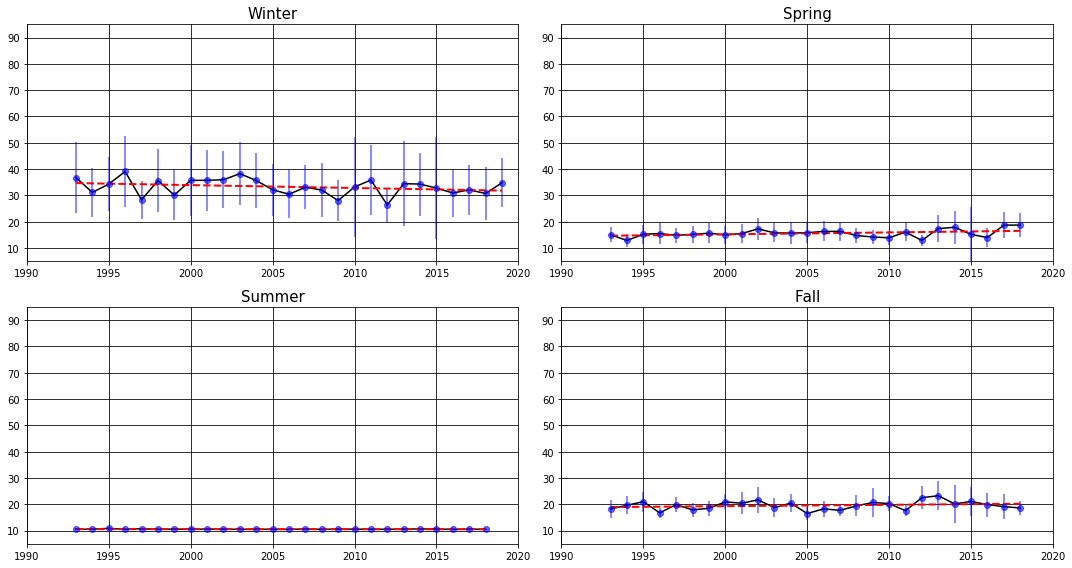

In [838]:
# Northern MAB
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

# winter
winter_mean = [36.770054, 31.142042, 34.29711, 39.093685, 28.30625, 35.639294, 30.135185, 35.716427, 35.736164, 35.96539, 38.25479, 35.676544, 32.146362, 30.457209, 33.116875, 32.049557, 28.020123, 33.22808, 35.838013, 26.383718, 34.4694, 34.317814, 32.79185, 30.916645, 32.117424, 30.730625, 34.82163]
winter_std = [13.586806, 9.362513, 10.287086, 13.329326, 7.187203, 11.906981, 9.399089, 13.546092, 11.711353, 10.787596, 12.056139, 10.312755, 9.941504, 9.151605, 8.371988, 10.28359, 7.80577, 19.15445, 13.3677225, 6.3505197, 16.100842, 11.982547, 19.41875, 9.016439, 9.50956, 10.136096, 9.324479]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,2019]
ax1.grid(True)
ax1.plot(years, winter_mean, color='k')
ax1.errorbar(years, winter_mean, winter_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax1.plot(np.unique(years), np.poly1d(np.polyfit(years, winter_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax1.set_title('Winter',fontsize = 15)

# spring
spring_mean = [15.054848, 12.871663, 15.246573, 15.501311, 14.865466, 15.158664, 15.650932, 14.993918, 15.514329, 17.288504, 15.766346, 15.688725, 15.825468, 16.32246, 16.353739, 14.773034, 14.187502, 13.903833, 16.06331, 12.872959, 17.404875, 17.88274, 15.211414, 13.977979, 18.719952, 18.71914]
spring_std = [2.9231014, 2.5206232, 3.5926476, 4.118152, 2.927525, 3.127883, 3.7099695, 3.5622096, 3.4421382, 4.0964203, 3.6585433, 4.106826, 4.0887456, 3.7756774, 3.5269482, 2.912831, 2.5516155, 2.6312246, 3.514176, 2.0750206, 5.005391, 6.26835, 10.369778, 3.4792354, 5.061653, 4.66826]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax2.grid(True)
ax2.plot(years, spring_mean, color='k')
ax2.errorbar(years, spring_mean, spring_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax2.plot(np.unique(years), np.poly1d(np.polyfit(years, spring_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax2.set_title('Spring',fontsize = 15)

# summer
summer_mean = [10.519576, 10.553357, 10.86757, 10.505116, 10.746422, 10.502064, 10.588994, 10.523938, 10.597058, 10.561394, 10.494787, 10.522016, 10.504027, 10.507658, 10.588938, 10.496962, 10.565794, 10.567437, 10.52477, 10.516831, 10.576235, 10.653781, 10.602333, 10.497291, 10.565369, 10.506336]
summer_std = [0.30509233, 0.31053653, 0.432637, 0.3072064, 0.3830769, 0.3000377, 0.34805456, 0.32440868, 0.4205677, 0.31767726, 0.29534253, 0.32734516, 0.29959545, 0.29727778, 0.3321211, 0.29600516, 0.36496282, 0.3250979, 0.3089074, 0.2990184, 0.3444243, 0.43988574, 0.43611088, 0.29627782, 0.3083531, 0.30003247]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax3.grid(True)
ax3.plot(years, summer_mean, color='k')
ax3.errorbar(years, summer_mean, summer_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax3.plot(np.unique(years), np.poly1d(np.polyfit(years, summer_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax3.set_title('Summer',fontsize = 15)

# autumn
fall_mean = [18.241215, 19.644905, 21.007675, 16.754456, 19.895668, 17.89298, 18.497526, 20.93133, 20.425026, 21.695145, 18.728878, 20.473356, 16.495766, 18.292526, 17.711588, 19.39352, 20.715965, 20.26855, 17.58872, 22.529211, 23.268002, 20.185848, 21.094181, 19.908503, 19.12535, 18.6215] 
fall_std = [3.5055032, 3.3446748, 3.8110275, 1.8671991, 2.9701014, 2.5443838, 2.8775983, 2.8525994, 4.1943126, 5.065935, 3.5660365, 3.3646688, 2.6230721, 3.0371325, 2.2602055, 3.9966464, 5.593052, 2.931764, 2.1359303, 4.352764, 5.4997907, 7.1069856, 5.345065, 4.588282, 4.789659, 2.777584]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax4.grid(True)
ax4.plot(years, fall_mean, color='k')
ax4.errorbar(years, fall_mean, fall_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax4.plot(np.unique(years), np.poly1d(np.polyfit(years, fall_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax4.set_title('Fall',fontsize = 15)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim((5,95))
    ax.set_xlim((1990,2020))

plt.savefig('Northern Mid-Atlantic Bight')
    
plt.tight_layout()

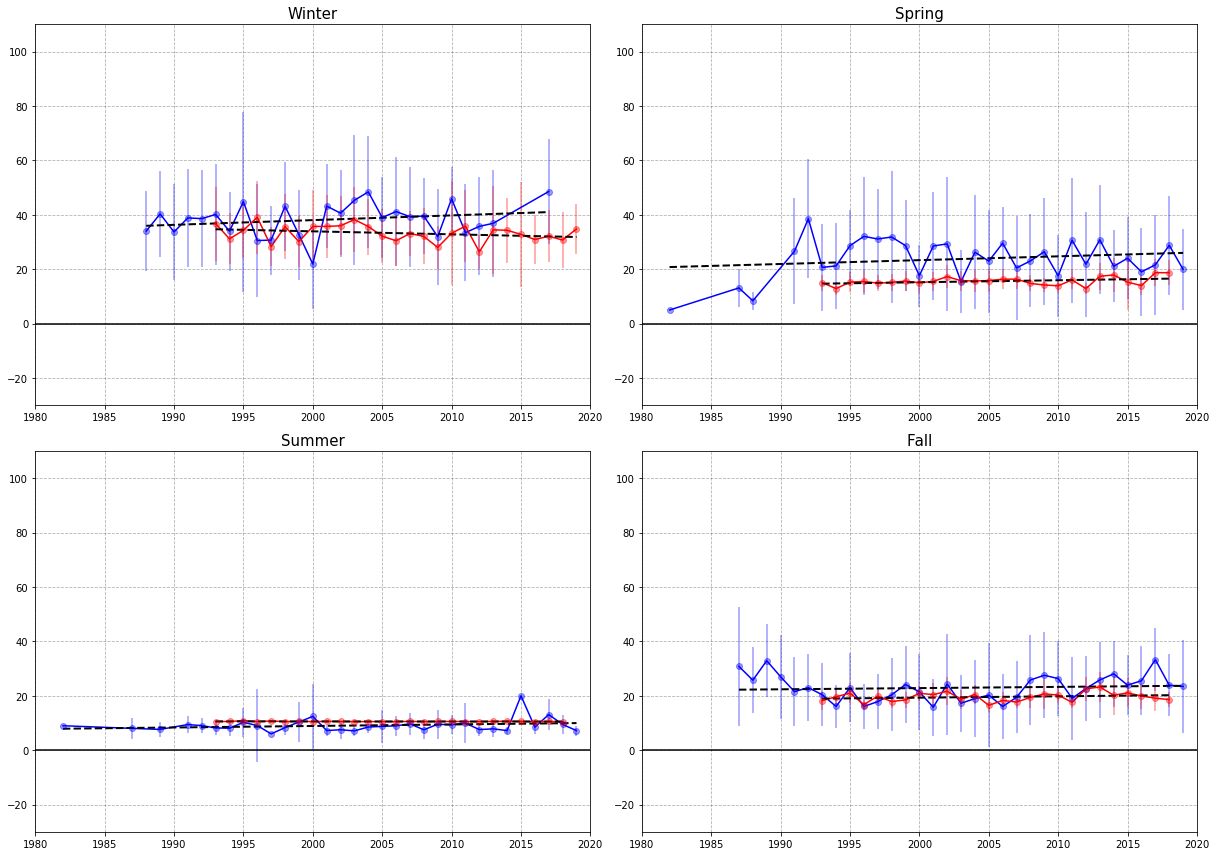

In [712]:
# Northern MAB
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(17,12))

# winter
winter_mean = [36.770054, 31.142042, 34.29711, 39.093685, 28.30625, 35.639294, 30.135185, 35.716427, 35.736164, 35.96539, 38.25479, 35.676544, 32.146362, 30.457209, 33.116875, 32.049557, 28.020123, 33.22808, 35.838013, 26.383718, 34.4694, 34.317814, 32.79185, 30.916645, 32.117424, 30.730625, 34.82163]
winter_std = [13.586806, 9.362513, 10.287086, 13.329326, 7.187203, 11.906981, 9.399089, 13.546092, 11.711353, 10.787596, 12.056139, 10.312755, 9.941504, 9.151605, 8.371988, 10.28359, 7.80577, 19.15445, 13.3677225, 6.3505197, 16.100842, 11.982547, 19.41875, 9.016439, 9.50956, 10.136096, 9.324479]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,2019]
ax1.axhline(y=0, color='black', linestyle='-')
ax1.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax1.plot(winter_year_NEFSC, winter_mean_NEFSC, color='blue')
ax1.errorbar(winter_year_NEFSC, winter_mean_NEFSC, winter_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax1.plot(np.unique(winter_year_NEFSC), np.poly1d(np.polyfit(winter_year_NEFSC, winter_mean_NEFSC, 1))(np.unique(winter_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')
ax1.plot(years, winter_mean, color='red')
ax1.errorbar(years, winter_mean, winter_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax1.plot(np.unique(years), np.poly1d(np.polyfit(years, winter_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax1.set_title('Winter',fontsize = 15)

# spring
spring_mean = [15.054848, 12.871663, 15.246573, 15.501311, 14.865466, 15.158664, 15.650932, 14.993918, 15.514329, 17.288504, 15.766346, 15.688725, 15.825468, 16.32246, 16.353739, 14.773034, 14.187502, 13.903833, 16.06331, 12.872959, 17.404875, 17.88274, 15.211414, 13.977979, 18.719952, 18.71914]
spring_std = [2.9231014, 2.5206232, 3.5926476, 4.118152, 2.927525, 3.127883, 3.7099695, 3.5622096, 3.4421382, 4.0964203, 3.6585433, 4.106826, 4.0887456, 3.7756774, 3.5269482, 2.912831, 2.5516155, 2.6312246, 3.514176, 2.0750206, 5.005391, 6.26835, 10.369778, 3.4792354, 5.061653, 4.66826]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax2.grid(True)
ax2.axhline(y=0, color='black', linestyle='-')
ax2.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax2.plot(spring_year_NEFSC, spring_mean_NEFSC, color='blue')
ax2.errorbar(spring_year_NEFSC, spring_mean_NEFSC, spring_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax2.plot(np.unique(spring_year_NEFSC), np.poly1d(np.polyfit(spring_year_NEFSC, spring_mean_NEFSC, 1))(np.unique(spring_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax2.plot(years, spring_mean, color='red')
ax2.errorbar(years, spring_mean, spring_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax2.plot(np.unique(years), np.poly1d(np.polyfit(years, spring_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax2.set_title('Spring',fontsize = 15)

# summer
summer_mean = [10.519576, 10.553357, 10.86757, 10.505116, 10.746422, 10.502064, 10.588994, 10.523938, 10.597058, 10.561394, 10.494787, 10.522016, 10.504027, 10.507658, 10.588938, 10.496962, 10.565794, 10.567437, 10.52477, 10.516831, 10.576235, 10.653781, 10.602333, 10.497291, 10.565369, 10.506336]
summer_std = [0.30509233, 0.31053653, 0.432637, 0.3072064, 0.3830769, 0.3000377, 0.34805456, 0.32440868, 0.4205677, 0.31767726, 0.29534253, 0.32734516, 0.29959545, 0.29727778, 0.3321211, 0.29600516, 0.36496282, 0.3250979, 0.3089074, 0.2990184, 0.3444243, 0.43988574, 0.43611088, 0.29627782, 0.3083531, 0.30003247]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax3.grid(True)
ax3.axhline(y=0, color='black', linestyle='-')
ax3.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax3.plot(summer_year_NEFSC, summer_mean_NEFSC, color='blue')
ax3.errorbar(summer_year_NEFSC, summer_mean_NEFSC, summer_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax3.plot(np.unique(summer_year_NEFSC), np.poly1d(np.polyfit(summer_year_NEFSC, summer_mean_NEFSC, 1))(np.unique(summer_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax3.plot(years, summer_mean, color='red')
ax3.errorbar(years, summer_mean, summer_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax3.plot(np.unique(years), np.poly1d(np.polyfit(years, summer_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax3.set_title('Summer',fontsize = 15)

# autumn
fall_mean = [18.241215, 19.644905, 21.007675, 16.754456, 19.895668, 17.89298, 18.497526, 20.93133, 20.425026, 21.695145, 18.728878, 20.473356, 16.495766, 18.292526, 17.711588, 19.39352, 20.715965, 20.26855, 17.58872, 22.529211, 23.268002, 20.185848, 21.094181, 19.908503, 19.12535, 18.6215] 
fall_std = [3.5055032, 3.3446748, 3.8110275, 1.8671991, 2.9701014, 2.5443838, 2.8775983, 2.8525994, 4.1943126, 5.065935, 3.5660365, 3.3646688, 2.6230721, 3.0371325, 2.2602055, 3.9966464, 5.593052, 2.931764, 2.1359303, 4.352764, 5.4997907, 7.1069856, 5.345065, 4.588282, 4.789659, 2.777584]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax4.grid(True)
ax4.axhline(y=0, color='black', linestyle='-')
ax4.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax4.plot(fall_year_NEFSC, fall_mean_NEFSC, color='blue')
ax4.errorbar(fall_year_NEFSC, fall_mean_NEFSC, fall_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax4.plot(np.unique(fall_year_NEFSC), np.poly1d(np.polyfit(fall_year_NEFSC, fall_mean_NEFSC, 1))(np.unique(fall_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax4.plot(years, fall_mean, color='red')
ax4.errorbar(years, fall_mean, fall_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax4.plot(np.unique(years), np.poly1d(np.polyfit(years, fall_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax4.set_title('Fall',fontsize = 15)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim((-30,110))
    ax.set_xlim((1980,2020))

plt.savefig('Southern Mid-Atlantic Bight')
    
plt.tight_layout()

In [839]:
import matplotlib.pyplot as plt; from scipy import stats

# winter
y = winter_mean
x = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

# spring
y = spring_mean
x = years
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

# summer
y = summer_mean
x = years
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

# fall
y = fall_mean
x = years
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

slope: -0.109462    pvalue: 0.159107
R-squared: 0.077712

slope: 0.073822    pvalue: 0.059695
R-squared: 0.139991

slope: -0.002528    pvalue: 0.259856
R-squared: 0.052572

slope: 0.050155    pvalue: 0.263706
R-squared: 0.051753



In [840]:
import matplotlib.pyplot as plt; from scipy import stats

# winter
y = winter_mean_NEFSC
x = winter_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# spring
y = spring_mean_NEFSC
x = spring_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# summer
y = summer_mean_NEFSC
x = summer_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# fall
y = fall_mean_NEFSC
x = fall_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)

slope: 0.173634
p_value: 0.247401
R-squared: 0.053129

slope: 0.140880
p_value: 0.286999
R-squared: 0.037692

slope: 0.055790
p_value: 0.219855
R-squared: 0.049737

slope: 0.044563
p_value: 0.609950
R-squared: 0.008495


### Georges Bank

In [235]:
import re
w = open("bndgb2.txt", "r", encoding="utf-8")
w.read()
w = '  40.00   69.50\n  40.30   68.00\n  40.40   67.50\n  40.60   67.00\n  40.80   66.50\n  41.45   66.00\n  41.80   65.70\n  42.10   66.00\n  42.10   67.00\n  42.10   67.50\n  41.80   68.00\n  41.10   69.00\n  41.00   69.50\n  40.00   69.50\n'
output1w = w.split('\n')

neww = [] 
for string in output1w:
    output2w = string.split(' ')
    neww.append(output2w)

neww = [['', '', '40.00', '', '', '69.50'], ['', '', '40.30', '', '', '68.00'], ['', '', '40.40', '', '', '67.50'], ['', '', '40.60', '', '', '67.00'], ['', '', '40.80', '', '', '66.50'], ['', '', '41.45', '', '', '66.00'], ['', '', '41.80', '', '', '65.70'], ['', '', '42.10', '', '', '66.00'], ['', '', '42.10', '', '', '67.00'], ['', '', '42.10', '', '', '67.50'], ['', '', '41.80', '', '', '68.00'], ['', '', '41.10', '', '', '69.00'], ['', '', '41.00', '', '', '69.50'], ['', '', '40.00', '', '', '69.50']]
lon_w = []; lat_w = []

for i in range(14): 
    w1 = neww[i][2]
    lat_w.append(w1)
    w3 = neww[i][5]
    lon_w.append(w3)
lonlist_w = [float(i)*-1 for i in lon_w]; latlist_w = [float(i) for i in lat_w]
lonlist_wneg = [float(i)*-1 for i in lon_w]
df_w = pd.DataFrame({'lon': lonlist_w, 'lat': latlist_w,})
df_w_plottable = pd.DataFrame({'lon': lonlist_wneg, 'lat': latlist_w,})


lonlist_w_plot = [float(i)*-1 for i in lon_w]; latlist_w = [float(i) for i in lat_w]
df_w_plot = pd.DataFrame({'lon': lonlist_w_plot, 'lat': latlist_w,})
x_w = df_w_plot['lon']; y_w = df_w_plot['lat']

In [236]:
polygon_w = Polygon(df_w.values)
print(polygon_w)

POLYGON ((-69.5 40, -68 40.3, -67.5 40.4, -67 40.6, -66.5 40.8, -66 41.45, -65.7 41.8, -66 42.1, -67 42.1, -67.5 42.1, -68 41.8, -69 41.1, -69.5 41, -69.5 40))


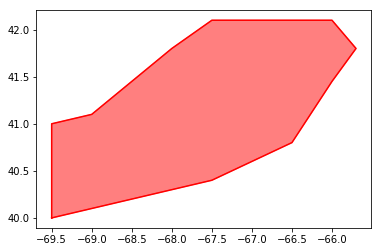

In [237]:
plt.fill(x_w,y_w,color='red',alpha=0.5)
plot(x_w,y_w,color='red') 

In [841]:
# NEFSC dataset
# winter
winter_mean_NEFSC = [47.0, 50.47540983606557, 50.28695652173913, 51.920731707317074, 48.507109004739334, 45.679245283018865, 45.15094339622642, 42.3780487804878, 56.95180722891566, 55.1356783919598, 54.79934640522876, 51.95820895522388, 45.796208530805686, 15.5, 52.86666666666667, 46.0, 36.5, 40.416666666666664, 47.34285714285714, 52.189189189189186, 47.333333333333336, 50.166666666666664, 44.256410256410255, 37.6530612244898, 44.53846153846154, 45.46875, 50.833333333333336, 53.4375]
winter_std_NEFSC = [21.975192625073642, 17.213954181977915, 16.839159257980693, 17.90807637523695, 18.38823890898135, 16.23612192375383, 20.02156706750368, 20.352231802817492, 21.237279472122136, 22.307689561059693, 17.98789613781279, 23.30789661844499, 31.66207262165831, 2.0816659994661326, 18.88391640657665, 25.337718918639855, 23.717082451262844, 27.480433810699612, 17.598366998344005, 22.820358646804145, 4.273952113286562, 17.649767299153996, 20.27536481431533, 20.500559972441568, 22.221243301088126, 17.59212502522722, 17.819546343385344, 15.345352348827882]
winter_year_NEFSC = [1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2017]
winter_ratiomean_NEFSC = [64.03920583785276, 83.98266205433136, 85.0775605442985, 85.04460842825064, 79.24948253838276, 78.37534836799065, 71.96454166598416, 70.24858823386865, 74.49255045846644, 71.9761103404982, 77.47247833234317, 70.9712280737417, 65.13214842065102, 16.45538236773869, 64.73330227916443, 68.91633455509368, 60.9037821094359, 39.9380868851669, 76.77777600560418, 73.80147940349426, 88.95474525092688, 71.82643785356004, 64.60471834041248, 57.00749657997256, 65.96205767797258, 66.95670525362645, 83.54600998878091, 72.52548076694384]
winter_ratiostd_NEFSC = [29.84630997549359, 17.348976946272, 18.39181466533851, 19.849067249122562, 24.209878004702517, 22.14562374168197, 29.65794534217568, 33.76186114599384, 28.439442712105162, 29.95542894025009, 25.713135032285606, 30.09487574907758, 31.60067621488937, 5.630860913788188, 31.927588419712844, 31.286542783170727, 40.00581486007741, 30.62252819702839, 25.454234561161638, 31.598512449983595, 4.347644060125159, 26.89175953207455, 35.18865731966698, 35.790726914210296, 30.400789665789407, 32.00851127833245, 23.16918926751023, 23.873301928361215]

# spring
spring_mean_NEFSC = [15.857142857142858, 38.7037037037037, 30.369668246445496, 50.51282051282051, 28.64666666666667, 24.83783783783784, 24.27777777777778, 38.766839378238345, 44.83764705882353, 41.98144876325088, 43.267682926829266, 36.54564755838641, 45.31578947368421, 37.15492957746479, 36.39080459770115, 37.035714285714285, 36.08450704225352, 34.170731707317074, 35.42857142857143, 33.40659340659341, 46.63636363636363, 40.40677966101695, 37.73684210526316, 41.12068965517241, 40.36231884057971, 45.14492753623188, 32.45360824742268, 29.02912621359223, 16.53846153846154, 32.20618556701031, 28.593023255813954, 28.99137931034483]
spring_std_NEFSC = [5.871642911161277, 32.18553762031686, 25.39677199930443, 23.33945360257897, 21.57359238785418, 20.444592278802475, 20.745204162560714, 24.64037264764152, 22.732644097380263, 23.661836462963414, 24.174576419732137, 23.840193513489503, 21.663133507954445, 22.648650472141945, 23.168922811145446, 19.30381473541099, 22.012818654380997, 25.036875243352945, 23.00445541507339, 23.274200318988417, 20.037405212639246, 22.486101948312964, 24.056871839596415, 22.79818212682672, 23.27645301870841, 22.703507996834297, 23.52703259840896, 24.2852558798663, 17.722751030692276, 22.024105233589086, 23.500877534042022, 22.85740130904427]
spring_year_NEFSC = [1982, 1987, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
spring_ratiomean_NEFSC = [12.267527175235777, 48.23352682163282, 45.672870833644495, 71.82128423725409, 41.954553543464925, 38.89393570468483, 38.36004092944907, 59.13897962849439, 65.12140304354239, 61.24764214236708, 63.44862088623191, 56.37650503705387, 65.17329815680921, 52.7217530901663, 55.40056475216416, 59.98133074208359, 54.74749141380998, 53.37287531126469, 53.886591977192744, 48.042016570149485, 68.02118076123378, 56.90962598541179, 57.14236860963826, 56.947841019623816, 57.66334561361539, 63.338136380098845, 47.162063561967415, 43.90042736108127, 27.780663074600863, 48.01325384898622, 43.382771589166744, 42.46470315235016]
spring_ratiostd_NEFSC = [5.142312499001814, 37.907345273170534, 37.17844234633802, 31.572341212115585, 34.072106329360814, 33.531148577004736, 33.637028365832, 36.566318501507716, 34.03989075104852, 34.32274139405323, 35.16514359383959, 37.026749096743856, 33.3987408808943, 35.052576062465, 36.06699915994699, 34.753879781817105, 34.62001232326084, 37.94336342864956, 37.68743991561755, 36.56992395327267, 33.00134723081575, 35.183890388323135, 39.70168099834528, 38.20444203914802, 37.524320346426556, 35.640311015081245, 39.57557576933964, 38.44583321609966, 34.39341892511004, 37.407957753423226, 38.22785895412805, 36.07788583967749]

# summer
summer_mean_NEFSC = [16.46153846153846, 16.5, 18.025, 16.20212765957447, 21.682142857142857, 20.01048951048951, 19.575562700964632, 17.112837837837837, 15.84840425531915, 17.06140350877193, 17.703125, 14.991935483870968, 13.68421052631579, 12.439024390243903, 17.1640625, 13.052631578947368, 13.874015748031496, 13.443661971830986, 14.99, 19.86080586080586, 18.03731343283582, 14.74468085106383, 13.101694915254237, 15.666666666666666, 13.121951219512194, 15.789473684210526, 18.846153846153847, 13.48, 16.095238095238095, 18.476190476190474]
summer_std_NEFSC = [12.427224043844122, 15.441878541914056, 17.255972581792943, 20.67078338493654, 17.76799009720047, 18.147250386811884, 18.894953608298845, 16.81591115825628, 14.424045862526222, 16.773319010279522, 15.961251986001283, 13.965402062240509, 12.870571350695336, 10.471710934734226, 16.961641459597505, 13.926861687854824, 14.369827365270835, 13.041953388851814, 15.540429514493782, 16.742503878240754, 20.136902389416075, 15.484946675819154, 13.078585505019673, 13.57505253330724, 12.870887929648092, 15.55662350417468, 18.63316160876789, 14.537652263461707, 16.07119757222039, 14.252493312447843]
summer_year_NEFSC = [1982, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
summer_ratiomean_NEFSC = [14.28503760001787, 24.89797336303667, 33.82828390324032, 17.662676915781606, 40.49902192644419, 34.82776704507483, 32.35105636718778, 29.434110578903077, 27.29461079380583, 28.365646639777175, 29.193800614982795, 26.184308317804483, 22.098155621204548, 20.050160024019164, 29.01175475687479, 21.101155750010864, 23.989831009477307, 23.77682270786971, 25.858959916685407, 40.988552405764324, 28.84230667505608, 23.74524738688745, 21.42930242673011, 23.55971439151135, 19.694216199993882, 22.209251978634505, 29.304728695770077, 14.253109690733238, 27.262275749832483, 33.2771543809537]
summer_ratiostd_NEFSC = [17.91854551608638, 26.74712682789302, 34.24915949240182, 22.42124750992583, 37.02451715682632, 34.698909340116444, 34.22241153970477, 32.05403070606478, 30.60574977870848, 32.211877396703834, 31.527598775340536, 29.662191705782455, 25.303016744838867, 23.244275256107564, 33.228287861688074, 27.097592848677373, 29.754818194150843, 26.47829719940029, 30.131234725934835, 36.26712909397492, 33.50905591024251, 30.158474298089505, 27.24162636162724, 29.50248903260222, 22.060306395503083, 32.57441466208273, 33.53260618754534, 20.02856723527842, 32.42459553895939, 32.952550396088945]

# fall
fall_mean_NEFSC = [16.076923076923077, 38.483870967741936, 20.54054054054054, 45.148148148148145, 41.77358490566038, 38.96774193548387, 32.385245901639344, 35.44347826086957, 33.30578512396694, 39.22826086956522, 26.62857142857143, 29.4020618556701, 33.94117647058823, 35.340425531914896, 39.71621621621622, 24.707070707070706, 28.840336134453782, 31.969072164948454, 26.283870967741937, 30.322314049586776, 24.896551724137932, 20.235294117647058, 21.46808510638298, 24.658333333333335, 30.13953488372093, 32.755319148936174, 29.396039603960396, 30.064814814814813, 38.273809523809526, 33.174311926605505, 31.068627450980394, 34.73684210526316, 24.353846153846153, 22.372881355932204, 33.180851063829785]
fall_std_NEFSC = [6.370001811375181, 21.53891202412034, 16.13931465327687, 12.841350587079418, 15.454202203525748, 19.234509076421464, 17.33502961035617, 18.702280236409408, 16.722162427552348, 21.70030802478987, 18.647008456311372, 20.729739000715874, 16.90348577752766, 20.51149858032133, 17.278159679931566, 15.837988769741557, 17.899428640288157, 17.884731388491357, 17.470849501982006, 18.747984280998075, 18.941272768558967, 12.741614477600487, 13.983632619601778, 17.69655325759453, 18.58373961039534, 18.076004817574567, 18.358147623287483, 16.584123219393906, 18.57861913402439, 20.37920328681925, 16.83128852301515, 16.776393188675947, 14.124923417083066, 15.919948779467015, 17.087984060968168]
fall_year_NEFSC = [1982, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
fall_ratiomean_NEFSC = [17.095921286859348, 53.84923842196102, 32.43797529641765, 81.68047267380464, 79.44448434758155, 68.66781705153932, 57.5708564213183, 61.33968199870938, 57.932562908048354, 58.93017091075045, 41.42459045361579, 47.833997497427454, 55.552697554257534, 56.83824232818916, 60.10482631562565, 41.67184635723964, 48.18087873429102, 51.936043897030224, 44.576168555473004, 52.32290095536043, 42.38762346614516, 33.34034205923868, 36.312887442154, 40.241436912004076, 47.91406141573398, 54.072794399586634, 43.89717673017305, 45.569094511273704, 55.572865838349, 47.283733425304, 46.09330041627762, 47.67251558499873, 36.647109053145684, 27.898306998350865, 48.02481938678933]
fall_ratiostd_NEFSC = [8.289456441574119, 34.72721678950214, 32.01229714031047, 18.40046416761363, 24.25936067694924, 34.5335612906462, 33.78250433688625, 33.06895408593811, 34.7043294284158, 33.36064610610465, 36.12073778212952, 36.38132168622639, 33.85671997062617, 31.58528036032334, 28.276851570821805, 32.335971046053686, 34.82021788690797, 32.79887881999566, 33.04443629164296, 35.10948951330899, 35.417443304713295, 27.508641665554727, 31.132261266861477, 33.19142914709125, 32.28351728029654, 32.925280103809136, 33.473056102023975, 31.961784691192445, 32.22498213742987, 35.82986848020612, 32.52931511665756, 30.79566547373256, 31.338907662961102, 25.716023260331976, 32.982246877896316]

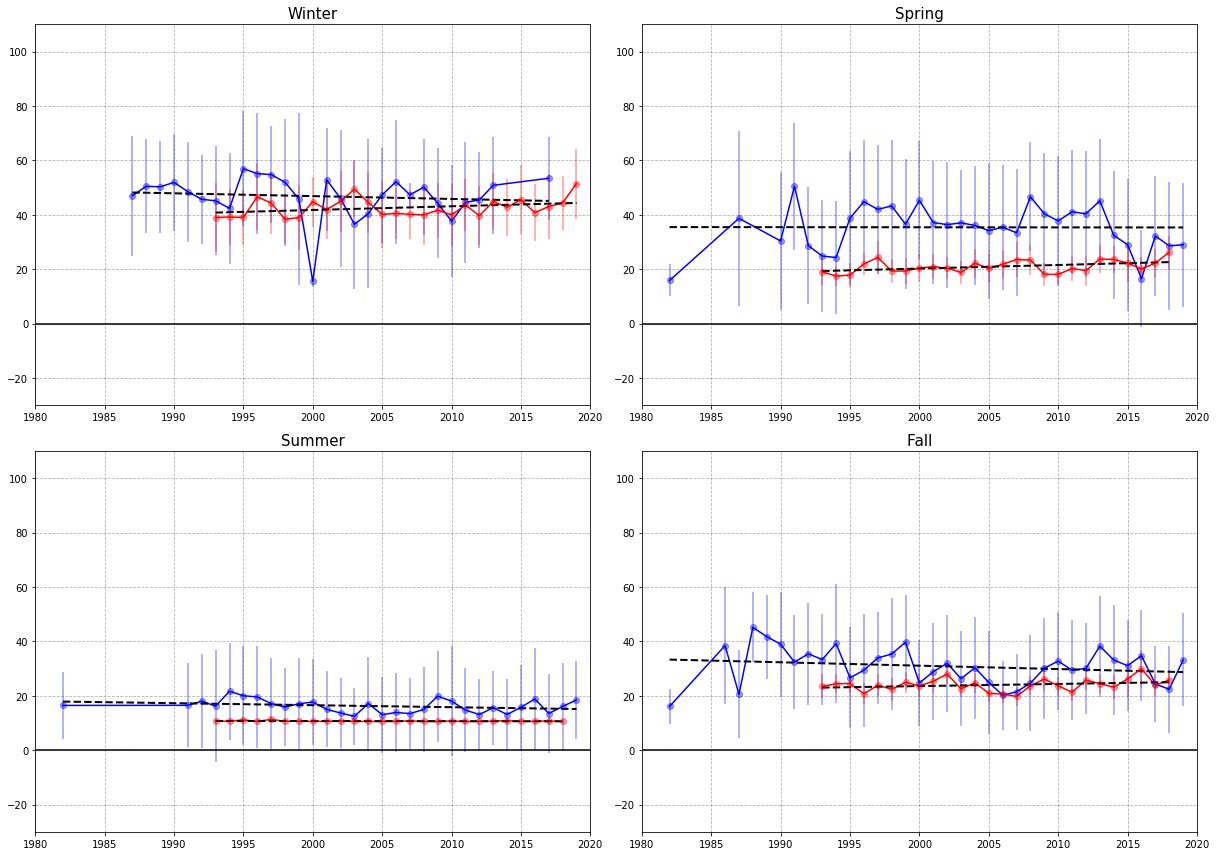

In [842]:
# Northern MAB
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(17,12))

# winter
winter_mean = [39.0049, 39.191357, 39.055115, 46.6183, 44.331924, 38.344147, 38.98975, 44.797253, 41.91232, 44.936153, 49.442474, 44.528538, 40.13777, 40.498833, 40.167133, 39.9718, 41.700718, 39.95164, 43.61991, 39.64479, 44.87744, 42.824303, 45.56318, 40.791397, 43.042374, 44.363457, 51.483032]
winter_std = [12.763689, 10.216573, 10.105525, 12.362383, 11.237961, 9.204937, 11.877417, 9.267653, 10.675496, 11.142955, 10.309052, 11.279501, 12.39917, 9.4904995, 9.113417, 11.097881, 10.069179, 11.415239, 9.5730915, 10.908127, 10.490206, 10.495303, 12.797247, 10.350098, 12.022437, 9.9154415, 12.848905]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
ax1.axhline(y=0, color='black', linestyle='-')
ax1.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax1.plot(winter_year_NEFSC, winter_mean_NEFSC, color='blue')
ax1.errorbar(winter_year_NEFSC, winter_mean_NEFSC, winter_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax1.plot(np.unique(winter_year_NEFSC), np.poly1d(np.polyfit(winter_year_NEFSC, winter_mean_NEFSC, 1))(np.unique(winter_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')
ax1.plot(years, winter_mean, color='red')
ax1.errorbar(years, winter_mean, winter_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax1.plot(np.unique(years), np.poly1d(np.polyfit(years, winter_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax1.set_title('Winter',fontsize = 15)

# spring
spring_mean = [19.005165, 17.468086, 17.81878, 21.906599, 24.337587, 19.344925, 19.331007, 20.431433, 20.924046, 20.40675, 18.812126, 22.220982, 20.26795, 21.801426, 23.5418, 23.376753, 18.107187, 18.098267, 20.24604, 19.46057, 23.748775, 23.588396, 22.274788, 20.050924, 22.256176, 26.24535]
spring_std = [4.9474, 3.791209, 4.6286955, 3.943816, 6.0321417, 4.255122, 4.7291803, 5.0636044, 4.5971184, 4.0975485, 4.335348, 5.3236895, 5.2550554, 4.8691, 6.398212, 5.677149, 4.135767, 3.611465, 4.7061224, 5.5135465, 5.042746, 4.8273335, 6.828121, 4.5319824, 5.0282807, 5.9931626]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax2.grid(True)
ax2.axhline(y=0, color='black', linestyle='-')
ax2.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax2.plot(spring_year_NEFSC, spring_mean_NEFSC, color='blue')
ax2.errorbar(spring_year_NEFSC, spring_mean_NEFSC, spring_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax2.plot(np.unique(spring_year_NEFSC), np.poly1d(np.polyfit(spring_year_NEFSC, spring_mean_NEFSC, 1))(np.unique(spring_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax2.plot(years, spring_mean, color='red')
ax2.errorbar(years, spring_mean, spring_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax2.plot(np.unique(years), np.poly1d(np.polyfit(years, spring_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax2.set_title('Spring',fontsize = 15)

# summer
summer_mean = [10.671555, 10.659716, 11.139045, 10.557141, 11.338085, 10.630441, 10.624901, 10.600217, 10.602863, 10.766074, 10.581306, 10.576504, 10.575117, 10.617575, 10.7778225, 10.577658, 10.566132, 10.751994, 10.5517435, 10.6320715, 10.671964, 10.859977, 10.608155, 10.615633, 10.791532, 10.561761]
summer_std = [0.28403783, 0.18261322, 0.7389918, 0.115271404, 0.6845291, 0.1625474, 0.21661846, 0.16955008, 0.13044024, 0.3234013, 0.115825385, 0.113603614, 0.13060834, 0.22151741, 0.28090623, 0.08135027, 0.10704906, 0.34386283, 0.07483379, 0.18368341, 0.24265757, 0.6126265, 0.20465165, 0.20527315, 0.36961192, 0.1017044]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax3.grid(True)
ax3.axhline(y=0, color='black', linestyle='-')
ax3.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax3.plot(summer_year_NEFSC, summer_mean_NEFSC, color='blue')
ax3.errorbar(summer_year_NEFSC, summer_mean_NEFSC, summer_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax3.plot(np.unique(summer_year_NEFSC), np.poly1d(np.polyfit(summer_year_NEFSC, summer_mean_NEFSC, 1))(np.unique(summer_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax3.plot(years, summer_mean, color='red')
ax3.errorbar(years, summer_mean, summer_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax3.plot(np.unique(years), np.poly1d(np.polyfit(years, summer_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax3.set_title('Summer',fontsize = 15)

# autumn
fall_mean = [23.463305, 24.41853, 24.513355, 20.693663, 23.917994, 22.383003, 24.968985, 23.644793, 25.341732, 28.007435, 22.573946, 24.76346, 20.89475, 20.619873, 19.761477, 23.655218, 26.168701, 23.694418, 21.303492, 25.76854, 24.50167, 23.132696, 26.204338, 29.945593, 23.90439, 25.820255]
fall_std = [4.4138737, 3.4646883, 3.5316124, 3.8671403, 3.9738977, 4.33392, 3.8089528, 4.2435265, 4.2305474, 3.7077243, 2.850134, 3.5885053, 3.0345564, 3.1331646, 3.4232712, 3.499382, 4.380353, 3.2212534, 3.0750008, 3.770061, 3.363268, 4.4465775, 6.7247977, 6.9488773, 3.8205752, 3.5962148]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax4.grid(True)
ax4.axhline(y=0, color='black', linestyle='-')
ax4.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax4.plot(fall_year_NEFSC, fall_mean_NEFSC, color='blue')
ax4.errorbar(fall_year_NEFSC, fall_mean_NEFSC, fall_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax4.plot(np.unique(fall_year_NEFSC), np.poly1d(np.polyfit(fall_year_NEFSC, fall_mean_NEFSC, 1))(np.unique(fall_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax4.plot(years, fall_mean, color='red')
ax4.errorbar(years, fall_mean, fall_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax4.plot(np.unique(years), np.poly1d(np.polyfit(years, fall_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax4.set_title('Fall',fontsize = 15)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim((-30,110))
    ax.set_xlim((1980,2020))

plt.savefig('Southern Mid-Atlantic Bight')
    
plt.tight_layout()

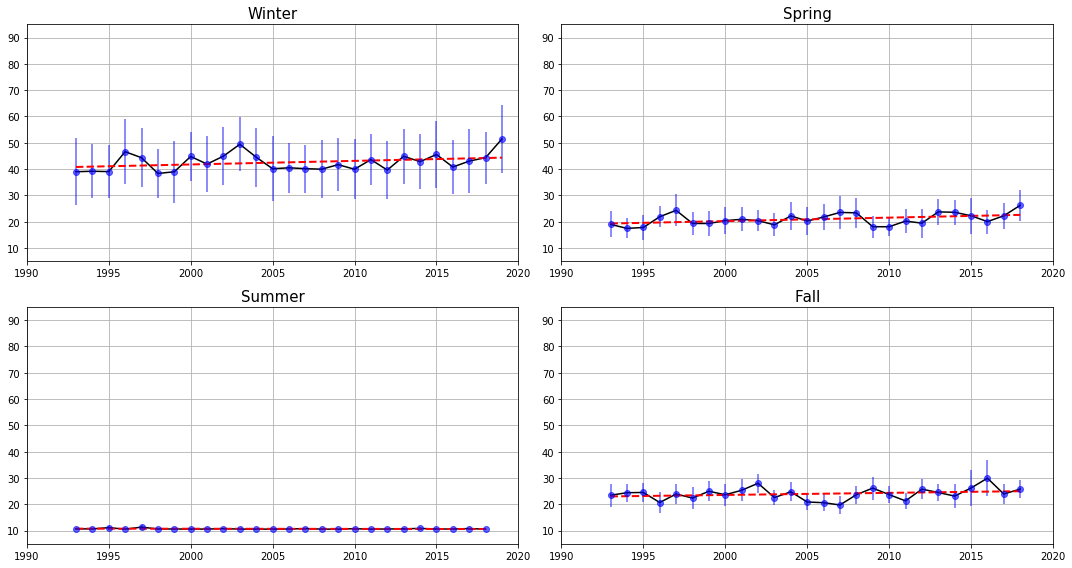

In [272]:
# Georges Bank
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

# winter
winter_mean = [39.0049, 39.191357, 39.055115, 46.6183, 44.331924, 38.344147, 38.98975, 44.797253, 41.91232, 44.936153, 49.442474, 44.528538, 40.13777, 40.498833, 40.167133, 39.9718, 41.700718, 39.95164, 43.61991, 39.64479, 44.87744, 42.824303, 45.56318, 40.791397, 43.042374, 44.363457, 51.483032]
winter_std = [12.763689, 10.216573, 10.105525, 12.362383, 11.237961, 9.204937, 11.877417, 9.267653, 10.675496, 11.142955, 10.309052, 11.279501, 12.39917, 9.4904995, 9.113417, 11.097881, 10.069179, 11.415239, 9.5730915, 10.908127, 10.490206, 10.495303, 12.797247, 10.350098, 12.022437, 9.9154415, 12.848905]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
ax1.grid(True)
ax1.plot(years, winter_mean, color='k')
ax1.errorbar(years, winter_mean, winter_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax1.plot(np.unique(years), np.poly1d(np.polyfit(years, winter_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax1.set_title('Winter',fontsize = 15)

# spring
spring_mean = [19.005165, 17.468086, 17.81878, 21.906599, 24.337587, 19.344925, 19.331007, 20.431433, 20.924046, 20.40675, 18.812126, 22.220982, 20.26795, 21.801426, 23.5418, 23.376753, 18.107187, 18.098267, 20.24604, 19.46057, 23.748775, 23.588396, 22.274788, 20.050924, 22.256176, 26.24535]
spring_std = [4.9474, 3.791209, 4.6286955, 3.943816, 6.0321417, 4.255122, 4.7291803, 5.0636044, 4.5971184, 4.0975485, 4.335348, 5.3236895, 5.2550554, 4.8691, 6.398212, 5.677149, 4.135767, 3.611465, 4.7061224, 5.5135465, 5.042746, 4.8273335, 6.828121, 4.5319824, 5.0282807, 5.9931626]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax2.grid(True)
ax2.plot(years, spring_mean, color='k')
ax2.errorbar(years, spring_mean, spring_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax2.plot(np.unique(years), np.poly1d(np.polyfit(years, spring_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax2.set_title('Spring',fontsize = 15)

# summer
summer_mean = [10.671555, 10.659716, 11.139045, 10.557141, 11.338085, 10.630441, 10.624901, 10.600217, 10.602863, 10.766074, 10.581306, 10.576504, 10.575117, 10.617575, 10.7778225, 10.577658, 10.566132, 10.751994, 10.5517435, 10.6320715, 10.671964, 10.859977, 10.608155, 10.615633, 10.791532, 10.561761]
summer_std = [0.28403783, 0.18261322, 0.7389918, 0.115271404, 0.6845291, 0.1625474, 0.21661846, 0.16955008, 0.13044024, 0.3234013, 0.115825385, 0.113603614, 0.13060834, 0.22151741, 0.28090623, 0.08135027, 0.10704906, 0.34386283, 0.07483379, 0.18368341, 0.24265757, 0.6126265, 0.20465165, 0.20527315, 0.36961192, 0.1017044]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax3.grid(True)
ax3.plot(years, summer_mean, color='k')
ax3.errorbar(years, summer_mean, summer_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax3.plot(np.unique(years), np.poly1d(np.polyfit(years, summer_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax3.set_title('Summer',fontsize = 15)

# autumn
fall_mean = [23.463305, 24.41853, 24.513355, 20.693663, 23.917994, 22.383003, 24.968985, 23.644793, 25.341732, 28.007435, 22.573946, 24.76346, 20.89475, 20.619873, 19.761477, 23.655218, 26.168701, 23.694418, 21.303492, 25.76854, 24.50167, 23.132696, 26.204338, 29.945593, 23.90439, 25.820255]
fall_std = [4.4138737, 3.4646883, 3.5316124, 3.8671403, 3.9738977, 4.33392, 3.8089528, 4.2435265, 4.2305474, 3.7077243, 2.850134, 3.5885053, 3.0345564, 3.1331646, 3.4232712, 3.499382, 4.380353, 3.2212534, 3.0750008, 3.770061, 3.363268, 4.4465775, 6.7247977, 6.9488773, 3.8205752, 3.5962148]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax4.grid(True)
ax4.plot(years, fall_mean, color='k')
ax4.errorbar(years, fall_mean, fall_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax4.plot(np.unique(years), np.poly1d(np.polyfit(years, fall_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax4.set_title('Fall',fontsize = 15)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim((5,95))
    ax.set_xlim((1990,2020))

plt.savefig('GeorgesBank')
    
plt.tight_layout()

In [843]:
import matplotlib.pyplot as plt; from scipy import stats

# winter
y = winter_mean
x = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

# spring
y = spring_mean
x = years
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

# summer
y = summer_mean
x = years
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

# fall
y = fall_mean
x = years
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

slope: 0.136376    pvalue: 0.098526
R-squared: 0.105378

slope: 0.131541    pvalue: 0.023979
R-squared: 0.194850

slope: -0.005849    pvalue: 0.230391
R-squared: 0.059355

slope: 0.079103    pvalue: 0.198428
R-squared: 0.067936



In [844]:
import matplotlib.pyplot as plt; from scipy import stats

# winter
y = winter_mean_NEFSC
x = winter_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# spring
y = spring_mean_NEFSC
x = spring_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# summer
y = summer_mean_NEFSC
x = summer_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# fall
y = fall_mean_NEFSC
x = fall_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)

slope: -0.103452
p_value: 0.578446
R-squared: 0.012032

slope: -0.003884
p_value: 0.979638
R-squared: 0.000022

slope: -0.073860
p_value: 0.124491
R-squared: 0.082212

slope: -0.124544
p_value: 0.267964
R-squared: 0.037048


In [970]:
print(winter_mean_NEFSC)
print(len(winter_mean_NEFSC))

[37.0, 91.71428571428571, 43.111111111111114, 50.625, 82.0, 53.0, 32.6, 31.88888888888889, 50.6, 74.08461538461539, 53.76086956521739, 52.63636363636363, 52.05882352941177, 39.0, 48.0625, 50.294117647058826, 52.42857142857143, 48.05882352941177, 55.55555555555556, 29.0, 40.54545454545455, 53.1764705882353, 59.75, 41.75]
24


In [971]:
print(winter_year_NEFSC)

[1987, 1988, 1989, 1990, 1991, 1992, 1993, 1995, 1996, 1997, 1998, 1999, 2002, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2017]


In [972]:
print(winter_mean)

[36.623253, 45.914562, 28.295898, 36.86922, 43.71068, 28.728888, 47.80346, 47.24041, 31.644535, 43.648006, 43.233067, 49.13547, 46.15124, 46.728214, 45.910736, 36.866432, 47.40409, 34.760696, 32.080605, 51.63476, 38.12856, 32.89712, 48.961903, 44.920334, 38.559666, 55.58722]


In [973]:
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
print(len(years))

27


In [985]:
workable = [32.6, 31.88888888888889, 50.6, 74.08461538461539, 53.76086956521739, 52.63636363636363, 52.05882352941177, 39.0, 48.0625, 50.294117647058826, 52.42857142857143, 48.05882352941177, 55.55555555555556, 29.0, 40.54545454545455, 53.1764705882353, 59.75, 41.75]
print(len(workable))

18


In [983]:
glorys_workable = [36.623253, 28.295898, 36.86922, 43.71068, 28.728888, 47.80346, 43.648006, 49.13547, 46.15124, 46.728214, 45.910736, 36.866432, 47.40409, 34.760696, 32.080605, 51.63476, 44.920334]

In [984]:
print(len(glorys_workable))

17


In [968]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(workable, spring_mean))

In [969]:
print(rms)

20.38751555850771


### Eastern Gulf of Maine

In [195]:
y = open("bndgme.txt", "r", encoding="utf-8")
y.read()
y = '  41.80   68.00\n  42.10   67.50\n  42.10   67.00\n  42.10   66.00\n  43.00   66.00\n  44.20   66.50\n  44.20   67.00\n  44.20   68.00\n  41.80   68.00\n'
output1y = y.split('\n')

newy = [] 
for string in output1y:
    output2y = string.split(' ')
    newy.append(output2y)
newy = [['', '', '41.80', '', '', '68.00'], ['', '', '42.10', '', '', '67.50'], ['', '', '42.10', '', '', '67.00'], ['', '', '42.10', '', '', '66.00'], ['', '', '43.00', '', '', '66.00'], ['', '', '44.20', '', '', '66.50'], ['', '', '44.20', '', '', '67.00'], ['', '', '44.20', '', '', '68.00'], ['', '', '41.80', '', '', '68.00']]
lon_y = []; lat_y = []

for i in range(9): 
    y1 = newy[i][2]
    lat_y.append(y1)
    y3 = newy[i][5]
    lon_y.append(y3)
lonlist_y = [float(i)*-1 for i in lon_y]; latlist_y = [float(i) for i in lat_y]
df_y = pd.DataFrame({'lon': lonlist_y, 'lat': latlist_y,})

lonlist_y_plot = [float(i)*-1 for i in lon_y]; latlist_y = [float(i) for i in lat_y]
df_y_plot = pd.DataFrame({'lon': lonlist_y_plot, 'lat': latlist_y,})
x_y = df_y_plot['lon']; y_y = df_y_plot['lat']

lonlist_yneg = [float(i)*-1 for i in lon_y]
df_y_plottable = pd.DataFrame({'lon': lonlist_yneg, 'lat': latlist_y,})

In [196]:
polygon_y = Polygon(df_y.values)
print(polygon_y)

POLYGON ((-68 41.8, -67.5 42.1, -67 42.1, -66 42.1, -66 43, -66.5 44.2, -67 44.2, -68 44.2, -68 41.8))


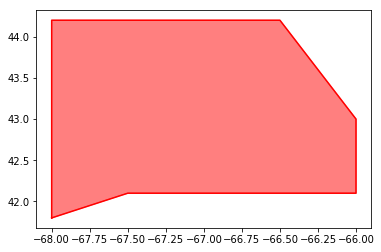

In [197]:
plt.fill(x_y,y_y,color='red',alpha=0.5)
plot(x_y,y_y,color='red') 

In [905]:
# NEFSC dataset
# winter
winter_mean_NEFSC = [37.0, 91.71428571428571, 43.111111111111114, 50.625, 82.0, 53.0, 32.6, 31.88888888888889, 50.6, 74.08461538461539, 53.76086956521739, 52.63636363636363, 52.05882352941177, 39.0, 48.0625, 50.294117647058826, 52.42857142857143, 48.05882352941177, 55.55555555555556, 29.0, 40.54545454545455, 53.1764705882353, 59.75, 41.75]
winter_std_NEFSC = [15.556349186104045, 36.913025188562216, 27.103710283116428, 25.433035322475483, 57.10224747474189, 26.242459234352765, 7.861297602813419, 21.477454359202675, 32.342610352976216, 29.1354312452408, 42.12387294559653, 26.80813563759398, 28.673747985385724, 0, 30.48599405191396, 24.224896041785072, 21.957000936145402, 28.234443921023338, 32.85480038741267, 12.727922061357855, 21.32677117688397, 38.23158918701531, 28.98706608127149, 21.572138115104465]
winter_year_NEFSC = [1987, 1988, 1989, 1990, 1991, 1992, 1993, 1995, 1996, 1997, 1998, 1999, 2002, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2017]
winter_ratiomean_NEFSC = [20.555555555555554, 73.17427684025607, 52.719573585717306, 63.542892396828286, 63.77778781149763, 65.39449225584028, 37.069070715061116, 26.502082629479446, 47.35995400276665, 50.28830138446505, 33.231541357888545, 40.800434251127356, 27.871879017953127, 10.893854748603351, 22.104462252960303, 35.65949978456803, 30.030628315262, 25.94288859808912, 29.096588246156944, 25.26143790849673, 19.594505916808316, 25.416113033857922, 30.47211329385881, 31.174456483469253]
winter_ratiostd_NEFSC = [8.642416214502248, 24.59487556821091, 43.42584884697833, 34.461500509633844, 30.503107404375125, 32.95879691102515, 19.973123740903898, 27.50120325283411, 36.22421303476545, 28.489360739369264, 29.031334077361098, 26.873210423962284, 19.921768531663243, 0, 10.90054416540377, 28.790499449277164, 21.20320548603689, 27.775574091425536, 22.305333548012072, 5.869448445143238, 14.077712392679162, 18.602209345377737, 18.248384008332337, 36.60007377719544]

# spring
spring_mean_NEFSC = [6.0, 43.0, 44.84, 43.29032258064516, 38.0, 38.06976744186046, 35.68518518518518, 50.56545454545454, 31.966666666666665, 32.776119402985074, 58.1764705882353, 46.78378378378378, 39.0, 39.791666666666664, 36.6875, 38.2972972972973, 33.696969696969695, 52.205882352941174, 33.28947368421053, 42.82051282051282, 22.771428571428572, 26.82758620689655, 30.294117647058822, 42.5, 28.053571428571427, 22.17241379310345, 24.22222222222222, 32.30769230769231, 35.473684210526315, 21.358974358974358]
spring_std_NEFSC = [0, 19.856149341366937, 16.667533310801172, 31.19315474949282, 24.78709341572747, 31.328060865040413, 28.206665928380264, 44.5033133106165, 29.56583216100215, 29.980206043484248, 24.42238241702376, 39.04138483365735, 26.778292011943613, 26.163933542946413, 17.87670587393622, 19.818432588635012, 31.327389023509493, 22.714005039962387, 29.511251079140063, 47.14751307549295, 19.71724493683536, 25.60422532864064, 37.5112218503461, 33.00454514154073, 27.21925764992475, 30.414757458581974, 56.61100908132931, 30.38624502368919, 49.16793040302753, 25.138026530890333]
spring_year_NEFSC = [1987, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
spring_ratiomean_NEFSC = [3.278688524590164, 32.225436076029574, 25.57187988458991, 30.834812676213634, 24.559323405611913, 35.379539297760196, 26.16741119078444, 36.51505930536455, 22.813489310832196, 22.934658147591076, 40.56068912291603, 29.085497592162508, 30.9630434971285, 27.890155088851117, 22.302208029741962, 23.743801466540173, 23.23343970798179, 34.74951369023244, 24.49205380784149, 27.520379365105047, 15.460561633518871, 16.476296258108412, 17.464561038811368, 24.29234041744438, 15.512979341812331, 12.15940345102789, 11.509230020440532, 19.153970984942582, 25.662565513171977, 16.84210396405355]
spring_ratiostd_NEFSC = [0, 26.318838867956984, 17.494265496686463, 29.211299043753147, 24.210268346926966, 34.81265158134295, 27.33012507502105, 32.92011967861671, 24.341382427740953, 24.916896572878137, 27.69060794659783, 28.887340212045903, 31.90262957615336, 26.79327452882333, 19.75108687050522, 21.32315637294259, 28.658840962715164, 22.418509374472638, 29.778068944571874, 32.529714482249425, 22.12986618832628, 20.890538520482988, 22.714093962889006, 24.49970418423706, 18.601180843221467, 16.228780277855186, 21.918378357377723, 24.800622527432097, 36.38421016799653, 27.05014777575777]

# summer
summer_mean_NEFSC = [12.5, 6.666666666666667, 7.0625, 8.12, 8.192307692307692, 10.18918918918919, 14.95, 8.35483870967742, 9.591836734693878, 10.070175438596491, 16.904761904761905, 16.0625, 11.4, 9.0, 27.372549019607842, 11.808510638297872, 9.297872340425531, 8.678571428571429, 9.5, 11.985915492957746, 18.27659574468085, 26.533333333333335, 9.625, 12.75, 9.4, 10.727272727272727, 15.64516129032258, 24.526315789473685, 38.7, 30.025641025641026]
summer_std_NEFSC = [3.271085446759225, 1.632993161855452, 2.048373338367138, 4.567274898667695, 2.926010673517522, 5.596813765377969, 25.553151651450627, 3.488537297080007, 4.8365723371814795, 9.070871058194244, 37.54717667402539, 33.726667419685796, 5.1705603059582455, 2.8444523358476395, 66.83800140169176, 26.023934048981793, 4.4031357088222105, 3.631059834945848, 4.001524099883845, 31.430873338053406, 39.14005072515629, 49.95772925828073, 8.080101699747404, 6.89832998063583, 6.542170893518451, 3.6902820784029258, 21.417358049172442, 55.18692319044494, 82.74125808491, 57.72142135404242]
summer_year_NEFSC = [1982, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
summer_ratiomean_NEFSC = [11.354282977000322, 6.522730637487466, 6.256131301762712, 6.170540590375171, 8.16637552396914, 9.434436563284287, 14.743106678307605, 9.495501011711296, 7.536626287429299, 9.27652168443373, 10.197635958187584, 9.378766246501538, 8.560055304843166, 6.183593658367044, 12.58074328403016, 7.827584892266759, 5.891081890818954, 7.7492949812217615, 9.828432480184155, 10.32768312184775, 10.234886061034485, 13.763448147443134, 6.573547660722748, 8.193387435385286, 11.957248873992372, 9.641379275052113, 10.140899868571914, 16.52313788175413, 19.515550595573878, 16.17045467880695]
summer_ratiostd_NEFSC = [7.711700192928468, 2.9295683089293467, 2.331648147758903, 7.158219607438054, 5.64622490215867, 10.291016067187199, 22.09736875731459, 3.4584384316582693, 4.946333634867345, 14.715484679926863, 20.416387803716756, 16.36297413232137, 5.187274614668299, 4.075680409143727, 23.07944376002395, 13.905771522195412, 4.175887767282979, 6.915171648829685, 7.359702108776137, 12.91073595189971, 16.89271444630459, 23.704719073452733, 10.258473042583086, 5.916987224084887, 8.897278292357283, 5.1156319602341345, 16.76842880760264, 30.174369089465223, 30.518482812140107, 27.655008580479016]

# fall
fall_mean_NEFSC = [12.227272727272727, 44.5, 25.857142857142858, 28.92, 30.934782608695652, 43.73809523809524, 25.666666666666668, 20.88235294117647, 28.34090909090909, 47.48571428571429, 28.11111111111111, 64.65217391304348, 26.3, 24.1, 38.779661016949156, 25.0, 26.658536585365855, 25.658227848101266, 28.9125, 27.569444444444443, 23.311827956989248, 30.20731707317073, 38.80722891566265, 34.29032258064516, 30.074074074074073, 41.40425531914894, 38.0, 35.048780487804876, 33.58536585365854, 39.111111111111114, 40.0, 44.484848484848484]
fall_std_NEFSC = [15.181228440732227, 20.42057785666214, 16.14959825535991, 20.80113811642948, 23.213408169430434, 20.604356067742525, 16.08903797177267, 8.623241508716259, 16.13596759779607, 30.22403740360956, 13.608523769752514, 44.76120214417062, 15.704873064583602, 18.97606753888978, 29.369270708549692, 15.123302738300444, 18.971205934839823, 18.119182409209, 25.73142380215436, 18.876042188475196, 15.559827381561549, 24.29384812891052, 29.294325526987386, 25.232289420550657, 20.810921278128088, 20.492479611531817, 26.31773073081477, 25.68652489099313, 17.431258717826573, 24.082124448410234, 14.120906486483083, 21.29131456151958]
fall_year_NEFSC = [1987, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
fall_ratiomean_NEFSC = [9.748585828221275, 52.82670117031281, 28.363273663371285, 25.266846582575813, 23.678516646365626, 30.988520031828365, 21.226625806440875, 12.885003897785566, 22.07101901267496, 36.34021659137396, 18.859824403011828, 38.1386765556545, 16.61725164138425, 13.320654372713422, 25.776233708148546, 15.364319225916, 15.789149191221178, 16.746279860164524, 19.14719575439166, 16.41476743063496, 14.494909599001113, 17.298869580658987, 23.07992699195452, 18.777744170024945, 17.308685964063717, 22.72865408710559, 22.697648115534633, 19.98264845908125, 19.657960063287884, 24.13929285897619, 27.223189736854366, 27.22178521319173]
fall_ratiostd_NEFSC = [19.509405198891635, 30.20654654408822, 26.147774904178966, 27.771010254818417, 26.09367286016016, 22.131805648979697, 22.64223390529291, 10.65270574794946, 19.30278993194563, 31.39654363982471, 14.521848825865694, 26.346475362014328, 16.679074450674236, 13.153335908270183, 26.820995655782788, 15.929370595925349, 15.080310205647084, 17.735642232333518, 18.53412324175105, 16.165673671054474, 12.99933322727664, 19.29118893239478, 24.01578425695874, 18.943614722326473, 15.832901862603968, 16.43058040082344, 20.46886591859575, 18.44832926566511, 16.593938979346106, 20.208380993033366, 23.281310588582386, 18.94143227410246]

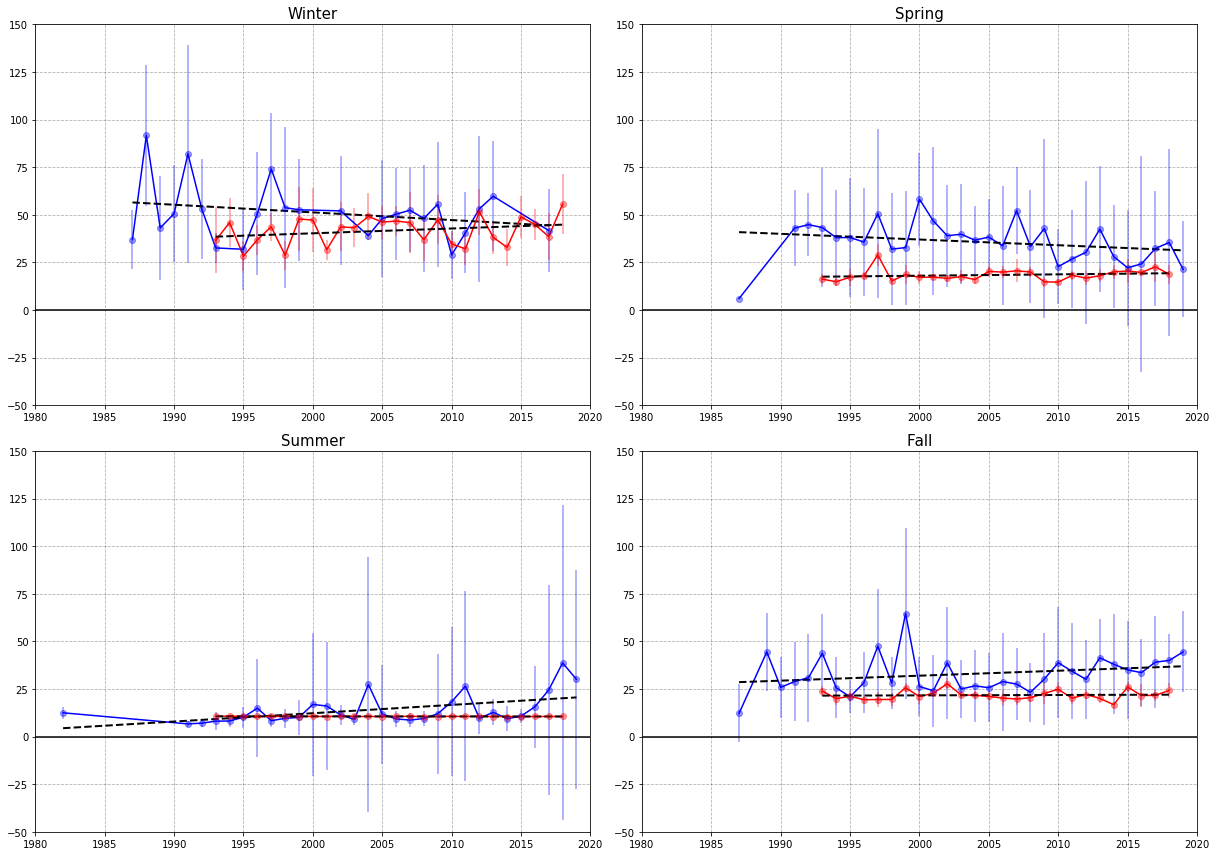

In [906]:
# Eastern GoM
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(17,12))

# winter
winter_mean = [36.623253, 45.914562, 28.295898, 36.86922, 43.71068, 28.728888, 47.80346, 47.24041, 31.644535, 43.648006, 43.233067, 49.13547, 46.15124, 46.728214, 45.910736, 36.866432, 47.40409, 34.760696, 32.080605, 51.63476, 38.12856, 32.89712, 48.961903, 44.920334, 38.559666, 55.58722]
winter_std = [17.42651, 12.726294, 7.7920547, 7.80366, 7.2819386, 7.5425477, 16.845074, 16.727495, 5.1232467, 12.891962, 10.125938, 12.19878, 8.7177105, 7.959933, 15.92185, 10.885306, 12.928996, 6.59589, 8.6439, 12.0752735, 8.771833, 9.670065, 11.005652, 8.077707, 12.507925, 15.86834]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax1.grid(True)
ax1.axhline(y=0, color='black', linestyle='-')
ax1.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax1.plot(winter_year_NEFSC, winter_mean_NEFSC, color='blue')
ax1.errorbar(winter_year_NEFSC, winter_mean_NEFSC, winter_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax1.plot(np.unique(winter_year_NEFSC), np.poly1d(np.polyfit(winter_year_NEFSC, winter_mean_NEFSC, 1))(np.unique(winter_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')
ax1.plot(years, winter_mean, color='red')
ax1.errorbar(years, winter_mean, winter_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax1.plot(np.unique(years), np.poly1d(np.polyfit(years, winter_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax1.set_title('Winter',fontsize = 15)

# spring
spring_mean = [16.214684, 14.84083, 17.24754, 17.893175, 28.963285, 15.233452, 18.646948, 17.124601, 17.295416, 16.60712, 17.531559, 15.996353, 20.256195, 19.91482, 20.571943, 19.956385, 14.798963, 14.638611, 18.205349, 16.734022, 18.02096, 20.03858, 20.470596, 19.7065, 22.701674, 18.780113]
spring_std = [2.8110106, 2.0660563, 4.4955378, 1.8048618, 5.9015846, 1.6163552, 4.971642, 3.3831348, 1.7382497, 1.9910387, 3.4363358, 2.5814316, 2.81911, 3.271787, 6.020949, 2.7006054, 2.6226676, 1.7438073, 2.3092036, 3.6217992, 3.2868173, 3.5286517, 6.4306016, 1.5634578, 7.758365, 4.871824]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax2.grid(True)
ax2.axhline(y=0, color='black', linestyle='-')
ax2.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax2.plot(spring_year_NEFSC, spring_mean_NEFSC, color='blue')
ax2.errorbar(spring_year_NEFSC, spring_mean_NEFSC, spring_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax2.plot(np.unique(spring_year_NEFSC), np.poly1d(np.polyfit(spring_year_NEFSC, spring_mean_NEFSC, 1))(np.unique(spring_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax2.plot(years, spring_mean, color='red')
ax2.errorbar(years, spring_mean, spring_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax2.plot(np.unique(years), np.poly1d(np.polyfit(years, spring_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax2.set_title('Spring',fontsize = 15)

# summer
summer_mean = [10.603919, 10.781447, 10.610981, 10.571529, 10.602375, 10.634841, 10.554851, 10.6136265, 10.536321, 10.750168, 10.586325, 10.563595, 10.539227, 10.564226, 10.674993, 10.540619, 10.546909, 10.631228, 10.584113, 10.628252, 10.5399275, 10.552327, 10.545934, 10.557322, 10.573357, 10.564694]
summer_std = [0.0648534, 0.17100823, 0.064677976, 0.039215118, 0.09832737, 0.079382956, 0.03605246, 0.07221098, 0.009227885, 0.11820523, 0.053742196, 0.040940177, 0.01654152, 0.056879632, 0.14046581, 0.012057903, 0.017370656, 0.08876739, 0.06413164, 0.0685181, 0.029614188, 0.033846516, 0.024654558, 0.029730195, 0.032109637, 0.03519865]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax3.grid(True)
ax3.axhline(y=0, color='black', linestyle='-')
ax3.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax3.plot(summer_year_NEFSC, summer_mean_NEFSC, color='blue')
ax3.errorbar(summer_year_NEFSC, summer_mean_NEFSC, summer_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax3.plot(np.unique(summer_year_NEFSC), np.poly1d(np.polyfit(summer_year_NEFSC, summer_mean_NEFSC, 1))(np.unique(summer_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax3.plot(years, summer_mean, color='red')
ax3.errorbar(years, summer_mean, summer_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax3.plot(np.unique(years), np.poly1d(np.polyfit(years, summer_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax3.set_title('Summer',fontsize = 15)

# autumn
fall_mean = [23.93502, 19.933065, 21.19783, 19.36952, 19.474545, 19.49511, 25.690977, 20.994905, 22.78601, 27.776234, 21.946707, 21.674675, 21.11088, 20.219233, 19.746824, 20.411667, 22.676876, 24.870586, 20.132664, 22.10745, 20.079147, 16.740314, 26.084274, 21.57006, 21.648006, 24.259436]
fall_std = [2.835996, 3.3975127, 2.966733, 2.4640682, 3.976932, 3.422367, 2.2839346, 3.9354053, 1.6211804, 2.9053187, 1.795107, 2.1341515, 2.125777, 4.130733, 3.1852658, 2.1906376, 5.7537026, 3.4975867, 2.9371743, 2.1269176, 2.6841745, 1.5422198, 2.6505165, 6.0474105, 3.0152564, 3.7400885]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax4.grid(True)
ax4.axhline(y=0, color='black', linestyle='-')
ax4.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax4.plot(fall_year_NEFSC, fall_mean_NEFSC, color='blue')
ax4.errorbar(fall_year_NEFSC, fall_mean_NEFSC, fall_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax4.plot(np.unique(fall_year_NEFSC), np.poly1d(np.polyfit(fall_year_NEFSC, fall_mean_NEFSC, 1))(np.unique(fall_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax4.plot(years, fall_mean, color='red')
ax4.errorbar(years, fall_mean, fall_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax4.plot(np.unique(years), np.poly1d(np.polyfit(years, fall_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax4.set_title('Fall',fontsize = 15)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim((-50,150))
    ax.set_xlim((1980,2020))

plt.savefig('Southern Mid-Atlantic Bight')
    
plt.tight_layout()

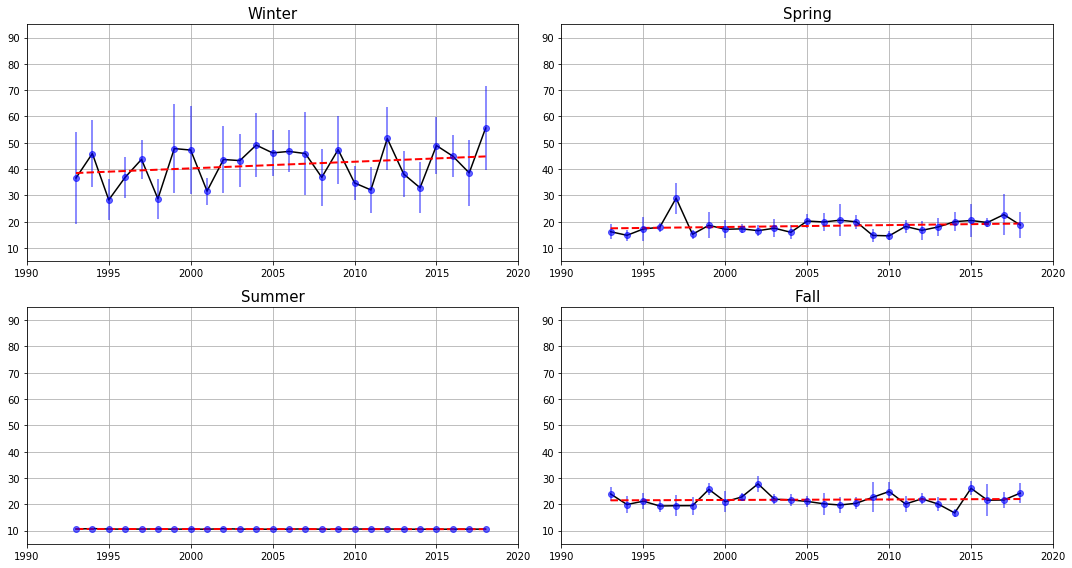

In [229]:
# Eastern Gulf of Maine
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

# winter
winter_mean = [36.623253, 45.914562, 28.295898, 36.86922, 43.71068, 28.728888, 47.80346, 47.24041, 31.644535, 43.648006, 43.233067, 49.13547, 46.15124, 46.728214, 45.910736, 36.866432, 47.40409, 34.760696, 32.080605, 51.63476, 38.12856, 32.89712, 48.961903, 44.920334, 38.559666, 55.58722]
winter_std = [17.42651, 12.726294, 7.7920547, 7.80366, 7.2819386, 7.5425477, 16.845074, 16.727495, 5.1232467, 12.891962, 10.125938, 12.19878, 8.7177105, 7.959933, 15.92185, 10.885306, 12.928996, 6.59589, 8.6439, 12.0752735, 8.771833, 9.670065, 11.005652, 8.077707, 12.507925, 15.86834]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax1.grid(True)
ax1.plot(years, winter_mean, color='k')
ax1.errorbar(years, winter_mean, winter_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax1.plot(np.unique(years), np.poly1d(np.polyfit(years, winter_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax1.set_title('Winter',fontsize = 15)

# spring
spring_mean = [16.214684, 14.84083, 17.24754, 17.893175, 28.963285, 15.233452, 18.646948, 17.124601, 17.295416, 16.60712, 17.531559, 15.996353, 20.256195, 19.91482, 20.571943, 19.956385, 14.798963, 14.638611, 18.205349, 16.734022, 18.02096, 20.03858, 20.470596, 19.7065, 22.701674, 18.780113]
spring_std = [2.8110106, 2.0660563, 4.4955378, 1.8048618, 5.9015846, 1.6163552, 4.971642, 3.3831348, 1.7382497, 1.9910387, 3.4363358, 2.5814316, 2.81911, 3.271787, 6.020949, 2.7006054, 2.6226676, 1.7438073, 2.3092036, 3.6217992, 3.2868173, 3.5286517, 6.4306016, 1.5634578, 7.758365, 4.871824]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax2.grid(True)
ax2.plot(years, spring_mean, color='k')
ax2.errorbar(years, spring_mean, spring_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax2.plot(np.unique(years), np.poly1d(np.polyfit(years, spring_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax2.set_title('Spring',fontsize = 15)

# summer
summer_mean = [10.603919, 10.781447, 10.610981, 10.571529, 10.602375, 10.634841, 10.554851, 10.6136265, 10.536321, 10.750168, 10.586325, 10.563595, 10.539227, 10.564226, 10.674993, 10.540619, 10.546909, 10.631228, 10.584113, 10.628252, 10.5399275, 10.552327, 10.545934, 10.557322, 10.573357, 10.564694]
summer_std = [0.0648534, 0.17100823, 0.064677976, 0.039215118, 0.09832737, 0.079382956, 0.03605246, 0.07221098, 0.009227885, 0.11820523, 0.053742196, 0.040940177, 0.01654152, 0.056879632, 0.14046581, 0.012057903, 0.017370656, 0.08876739, 0.06413164, 0.0685181, 0.029614188, 0.033846516, 0.024654558, 0.029730195, 0.032109637, 0.03519865]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax3.grid(True)
ax3.plot(years, summer_mean, color='k')
ax3.errorbar(years, summer_mean, summer_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax3.plot(np.unique(years), np.poly1d(np.polyfit(years, summer_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax3.set_title('Summer',fontsize = 15)

# autumn
fall_mean = [23.93502, 19.933065, 21.19783, 19.36952, 19.474545, 19.49511, 25.690977, 20.994905, 22.78601, 27.776234, 21.946707, 21.674675, 21.11088, 20.219233, 19.746824, 20.411667, 22.676876, 24.870586, 20.132664, 22.10745, 20.079147, 16.740314, 26.084274, 21.57006, 21.648006, 24.259436]
fall_std = [2.835996, 3.3975127, 2.966733, 2.4640682, 3.976932, 3.422367, 2.2839346, 3.9354053, 1.6211804, 2.9053187, 1.795107, 2.1341515, 2.125777, 4.130733, 3.1852658, 2.1906376, 5.7537026, 3.4975867, 2.9371743, 2.1269176, 2.6841745, 1.5422198, 2.6505165, 6.0474105, 3.0152564, 3.7400885]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax4.grid(True)
ax4.plot(years, fall_mean, color='k')
ax4.errorbar(years, fall_mean, fall_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax4.plot(np.unique(years), np.poly1d(np.polyfit(years, fall_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax4.set_title('Fall',fontsize = 15)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim((5,95))
    ax.set_xlim((1990,2020))

plt.savefig('EasternGoM')
    
plt.tight_layout()

In [847]:
import matplotlib.pyplot as plt; from scipy import stats

# winter
y = winter_mean
x = years
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

# spring
y = spring_mean
x = years
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

# summer
y = summer_mean
x = years
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

# fall
y = fall_mean
x = years
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

slope: 0.252113    pvalue: 0.197607
R-squared: 0.068177

slope: 0.072341    pvalue: 0.365528
R-squared: 0.034233

slope: -0.003235    pvalue: 0.043472
R-squared: 0.159194

slope: 0.019786    pvalue: 0.766384
R-squared: 0.003748



In [907]:
import matplotlib.pyplot as plt; from scipy import stats

# winter
y = winter_mean_NEFSC
x = winter_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# spring
y = spring_mean_NEFSC
x = spring_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# summer
y = summer_mean_NEFSC
x = summer_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# fall
y = fall_mean_NEFSC
x = fall_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)

slope: -0.402039
p_value: 0.250939
R-squared: 0.059442

slope: -0.299284
p_value: 0.174625
R-squared: 0.064798

slope: 0.436935
p_value: 0.002942
R-squared: 0.274842

slope: 0.260395
p_value: 0.170525
R-squared: 0.061673


In [929]:
print(winter_mean_NEFSC)
print(len(winter_mean_NEFSC))
print(winter_year_NEFSC)

[37.0, 91.71428571428571, 43.111111111111114, 50.625, 82.0, 53.0, 32.6, 31.88888888888889, 50.6, 74.08461538461539, 53.76086956521739, 52.63636363636363, 52.05882352941177, 39.0, 48.0625, 50.294117647058826, 52.42857142857143, 48.05882352941177, 55.55555555555556, 29.0, 40.54545454545455, 53.1764705882353, 59.75, 41.75]
24
[1987, 1988, 1989, 1990, 1991, 1992, 1993, 1995, 1996, 1997, 1998, 1999, 2002, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2017]


In [930]:
workable = [32.6, 31.88888888888889, 50.6, 74.08461538461539, 53.76086956521739, 52.63636363636363, 52.05882352941177, 39.0, 48.0625, 50.294117647058826, 52.42857142857143, 48.05882352941177, 55.55555555555556, 29.0, 40.54545454545455, 53.1764705882353, 59.75, 41.75]


In [931]:
print(len(workable))

18


In [937]:
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
print(years)

[1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [932]:
print(winter_mean)
print(len(winter_mean))

[36.623253, 45.914562, 28.295898, 36.86922, 43.71068, 28.728888, 47.80346, 47.24041, 31.644535, 43.648006, 43.233067, 49.13547, 46.15124, 46.728214, 45.910736, 36.866432, 47.40409, 34.760696, 32.080605, 51.63476, 38.12856, 32.89712, 48.961903, 44.920334, 38.559666, 55.58722]
26


In [940]:
glorys_workable = [36.623253, 28.295898, 36.86922, 43.71068, 28.728888, 47.80346, 43.648006, 49.13547, 46.15124, 46.728214, 45.910736, 36.866432, 47.40409, 34.760696, 32.080605, 51.63476, 38.12856, 38.559666]

In [941]:
print(len(glorys_workable))

18


In [942]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(workable, glorys_workable))

In [943]:
print(rms)

12.470144185809684


### Western Gulf of Maine

In [185]:
t = open("bndgmw.txt", "r", encoding="utf-8")
t.read()
t = '  42.20   70.50\n  42.00   70.00\n  41.10   69.00\n  41.80   68.00\n  44.20   68.00\n  43.90   69.00\n  43.70   70.00\n  43.00   70.50\n  42.20   70.50'
output1t = t.split('\n')
newt = [] 
for string in output1t:
    output2t = string.split(' ')
    newt.append(output2t)
lon_t = []; lat_t = []

for i in range(9): 
    t1 = newt[i][2]
    lat_t.append(t1)
    t3 = newt[i][5]
    lon_t.append(t3)
lonlist_t = [float(i)*-1 for i in lon_t]; latlist_t = [float(i) for i in lat_t]
df_t = pd.DataFrame({'lon': lonlist_t, 'lat': latlist_t,})

lonlist_t_plot = [float(i)*-1 for i in lon_t]; latlist_t = [float(i) for i in lat_t]
df_t_plot = pd.DataFrame({'lon': lonlist_t_plot, 'lat': latlist_t,})
x_t = df_t_plot['lon']; y_t = df_t_plot['lat']

In [186]:
polygon_t = Polygon(df_t.values)
print(polygon_t)

POLYGON ((-70.5 42.2, -70 42, -69 41.1, -68 41.8, -68 44.2, -69 43.9, -70 43.7, -70.5 43, -70.5 42.2))


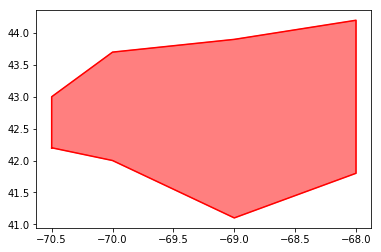

In [187]:
plt.fill(x_t,y_t,color='red',alpha=0.5)
plot(x_t,y_t,color='red') 

In [850]:
# NEFSC dataset
# winter
winter_mean_NEFSC = [34.0, 40.333333333333336, 33.68539325842696, 38.86363636363637, 38.59, 40.12931034482759, 33.95652173913044, 44.851063829787236, 30.53846153846154, 30.694444444444443, 43.15151515151515, 32.72222222222222, 21.92105263157895, 43.21951219512195, 40.59183673469388, 45.333333333333336, 48.425, 39.0, 41.19047619047619, 39.30555555555556, 39.54545454545455, 31.9375, 45.88235294117647, 33.44230769230769, 35.75, 36.875, 48.56521739130435]
winter_std_NEFSC = [14.721984992020035, 15.70687372945174, 17.742857401333218, 18.153991244878416, 17.778147407773545, 18.460076862816944, 14.510072346080534, 33.096682300170905, 20.677003204972948, 12.644184308424045, 16.351837075924397, 16.572974749980524, 16.69986499208637, 15.430468808832195, 15.934656108812717, 23.91898089507209, 20.649563849618886, 14.779866184930244, 19.93065795695115, 18.340929162386583, 13.978647910388093, 17.60487011065129, 11.787936067019647, 17.931693337292067, 17.966756741996786, 19.76231041764799, 19.37389548043853]
winter_year_NEFSC = [1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2017]
winter_ratiomean_NEFSC = [76.23306681646422, 89.0118981365219, 63.563542840327095, 70.4913565481966, 74.61951134294749, 67.80106591026636, 60.61574086236507, 65.65393269499219, 48.65770251617613, 52.63708242119741, 64.3746635392609, 48.53039757522891, 34.779315965100366, 60.47859989981051, 62.265164606578175, 56.049681493110505, 64.97502852927231, 53.61790297364032, 59.81631656100218, 58.86123397370342, 60.081617654394236, 56.335890230369145, 71.51924539698423, 63.17510471494319, 54.865809557269806, 65.8467026400928, 73.09590614223274]
winter_ratiostd_NEFSC = [15.96282438367346, 6.604521318130069, 27.724783491570438, 27.24082376697938, 21.66120313883902, 25.67198027269401, 26.444509500561143, 28.220726638623596, 33.75462209094246, 25.73263431671923, 30.47767890947114, 30.724468580526732, 27.163408325909817, 29.35602521533741, 31.577516552598915, 33.68715000940876, 22.267375005384434, 31.04880242192425, 28.670640728929776, 30.80917587894595, 30.427850808892863, 26.58126837578002, 23.298774668950397, 27.763498805019278, 30.485511173335787, 31.619615241906512, 25.142280322742174]

# spring
spring_mean_NEFSC = [5.0, 13.116279069767442, 8.375, 26.607843137254903, 38.55882352941177, 20.64, 21.22641509433962, 28.64, 32.07692307692308, 31.103448275862068, 31.833333333333332, 28.666666666666668, 17.635135135135137, 28.529411764705884, 29.31578947368421, 15.428571428571429, 26.25, 22.963414634146343, 29.571428571428573, 20.458823529411763, 23.053333333333335, 26.42105263157895, 17.539473684210527, 30.64179104477612, 21.80701754385965, 30.8125, 21.058252427184467, 24.039473684210527, 19.01298701298701, 21.613333333333333, 28.78048780487805, 19.941176470588236]
spring_std_NEFSC = [0, 6.920419240362559, 3.3354160160315836, 19.52135080507755, 21.96631230332482, 15.979272288096942, 15.784171123475328, 13.03482514906382, 21.67391687489479, 18.507172298794803, 24.086109952433013, 16.633299933166196, 11.413251519854494, 19.789542382493746, 24.73173967533261, 11.541591455831961, 20.93744651734463, 18.97005119964925, 13.212998650319062, 19.248100055389802, 17.07684803289936, 19.75062068755966, 15.085923495739273, 23.062301320512237, 19.281225691340293, 20.06018205937621, 13.250841810268275, 15.143263223381927, 16.0930628291669, 18.316211497020984, 18.187653110971592, 14.927675422497693]
spring_year_NEFSC = [1982, 1987, 1988, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
spring_ratiomean_NEFSC = [3.571428571428571, 42.93932630246024, 29.39818852250794, 59.05074771102793, 66.70543349309388, 48.598995464442666, 47.793973765023544, 59.15364222018222, 63.02290583014726, 67.29347318192262, 59.06422205104862, 59.25455864655319, 38.105624342764294, 57.19989115281585, 53.55233462158589, 36.673544545497485, 54.57096461867553, 44.066634602500855, 61.72621367478824, 39.05792518192078, 52.67780811213988, 43.13564407277732, 32.92920800742039, 51.66029498177808, 40.198220850783436, 53.97003234164474, 44.31043703449151, 44.653479267450535, 36.55757016185993, 37.31177479961987, 54.21550366944955, 42.74812851312627]
spring_ratiostd_NEFSC = [0, 24.87575397579526, 12.93256052631026, 31.45317974078662, 26.724109620123883, 28.73950436975683, 32.30343303036974, 25.0444158016482, 26.74768587571801, 23.106389287021102, 30.60271591499436, 26.220368634490836, 23.847158451463777, 26.130986316442968, 31.88116117046772, 22.997812181215203, 31.949987518736776, 29.26851294086835, 24.544890596780792, 30.778195782467392, 29.847669520933778, 30.20002031389174, 29.007110777489032, 32.276831196969056, 32.185302684021195, 26.265638220468762, 29.58391270130518, 31.68416823356412, 32.23248451107555, 27.997782771209078, 33.73799025115779, 31.868086478716716]

# summer
summer_mean_NEFSC = [9.0, 8.01923076923077, 7.641304347826087, 9.434782608695652, 9.029411764705882, 8.181818181818182, 8.081632653061224, 10.241379310344827, 9.064102564102564, 6.0, 8.3125, 10.363636363636363, 12.421052631578947, 7.235294117647059, 7.512820512820513, 7.111111111111111, 8.524590163934427, 8.75, 8.969696969696969, 9.692307692307692, 7.5, 9.533333333333333, 9.344827586206897, 9.93421052631579, 7.590361445783133, 7.852459016393443, 7.2, 20.0, 8.46875, 13.1, 9.458333333333334, 7.212121212121212]
summer_std_NEFSC = [0, 3.7337379925058682, 2.869243962674406, 3.1884177745612856, 2.822907314117809, 2.7539817690782895, 2.8272243064375995, 5.234877351638671, 13.253119940043858, 0.0, 2.6933310710093767, 7.486704211982513, 12.019963900267866, 1.855040827202527, 3.2352645289372757, 1.8751906221184675, 2.3707000188203846, 6.109051712050964, 3.594738449754658, 4.079175911058546, 3.5552123542372165, 5.400336689840399, 3.4874864266911034, 7.285301231595556, 2.2525657164194186, 3.166681046846843, 1.3038404810405297, 0, 2.5940637360455634, 5.8395205282625735, 3.5012937567439972, 1.8499590495058222]
summer_year_NEFSC = [1982, 1987, 1989, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
summer_ratiomean_NEFSC = [6.122448979591836, 31.82837093707801, 35.20179720866257, 17.067445239272118, 19.698026045536846, 15.246048008804406, 16.8713498420773, 17.249302809772242, 15.090827157788445, 16.34782608695652, 11.361931684612216, 19.78108290068821, 25.202349802138947, 13.836441290084217, 14.56984260935245, 12.773650401140713, 14.89032590278855, 14.49009179287616, 17.23294773780999, 18.993245607921285, 15.717518519242885, 18.295972065145776, 16.912254981101384, 20.32683207746701, 14.35004783147652, 14.708461393114414, 11.425879220961189, 12.195121951219512, 12.695104738254672, 29.301968794387605, 16.97612257932965, 13.04921379603215]
summer_ratiostd_NEFSC = [0, 17.19324047957339, 16.477228420516276, 7.207124204435687, 5.867480737583194, 6.3691562825027015, 6.117731771179673, 11.451505947011796, 10.79755037584715, 10.821808129463683, 4.117549957727322, 17.81839750883237, 25.913729874764297, 4.091755036168111, 11.29417564030816, 2.993322176576243, 6.098250361530334, 10.607731288239936, 12.62838613292879, 11.454708067860068, 13.727314173250937, 15.061920235998969, 10.556727396907474, 22.58627546424538, 10.699558297904995, 11.261807643237724, 1.743958036900585, 0, 5.615587866164289, 19.881997758489955, 8.027012621753157, 6.96040538551399]

# fall
fall_mean_NEFSC = [30.8125, 25.73076923076923, 32.90243902439025, 27.022222222222222, 21.52054794520548, 23.01492537313433, 20.380281690140844, 16.076190476190476, 23.0, 16.08, 17.87037037037037, 20.35135135135135, 24.15068493150685, 21.441558441558442, 15.780821917808218, 24.333333333333332, 17.25925925925926, 18.970588235294116, 20.25925925925926, 16.075949367088608, 19.45205479452055, 25.819148936170212, 27.55, 26.333333333333332, 19.068493150684933, 22.658227848101266, 25.83076923076923, 28.074626865671643, 23.901408450704224, 25.55223880597015, 33.30769230769231, 23.880597014925375, 23.444444444444443]
fall_std_NEFSC = [21.95807956230499, 12.081581659063326, 13.525540429219049, 15.368931010452236, 12.69635729587329, 12.230727000014836, 11.57135156593102, 7.911402722671438, 12.790161660202644, 8.148719694102947, 10.140608251445975, 13.417870349805003, 14.33010742077741, 13.86446945716916, 10.401985087449075, 18.564957787661616, 10.455593930736047, 14.23467553927789, 19.144044620832986, 12.020038986133642, 13.168819545395026, 16.67782170735467, 15.874746478529216, 13.764083696345356, 15.273732687128877, 11.794051168833409, 13.925661149889383, 12.068382725166014, 10.919386337515839, 12.613465126108771, 11.568125970162084, 11.411746192118201, 17.0945897874152]
fall_year_NEFSC = [1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
fall_ratiomean_NEFSC = [49.98204755881757, 68.44558466700596, 73.006079560968, 55.10923078218703, 49.03449202612406, 54.24866629260602, 50.591544426342736, 36.182328633544124, 59.024316504567174, 43.64087329008624, 41.92636895440721, 44.23276749215555, 52.85681065468227, 43.20218956666565, 37.254687249148844, 48.51018682111196, 39.423453892903375, 42.767754485674985, 38.53733207951795, 34.95193276568464, 43.77138269412342, 52.92878179240334, 48.36443806276189, 49.769464004764124, 38.10724208721931, 39.546836927168535, 45.625522626806436, 48.88856962050422, 43.68603423743653, 45.26151854474648, 60.956147833665554, 49.67700339541586, 37.11757273807868]
fall_ratiostd_NEFSC = [32.23248081869434, 22.472612273891496, 22.11251695877329, 32.14256545958259, 24.32532119648501, 25.913750115253194, 29.66756562778075, 27.254998741387197, 29.795929139199416, 28.22567935233443, 21.765344606887716, 26.565073103495497, 23.068242144955022, 24.003908481155413, 24.00223241752343, 27.478969383897006, 25.631156368191064, 26.382865201080147, 26.178800555794023, 22.634405477008205, 26.60628085873182, 28.139074881425906, 28.328179967849447, 31.576990646018654, 31.064796484890877, 26.108809719875453, 26.397284362510458, 26.373569897117218, 27.572690983954384, 27.98686711305274, 29.26136655362705, 27.37508202529949, 24.544176612433517]

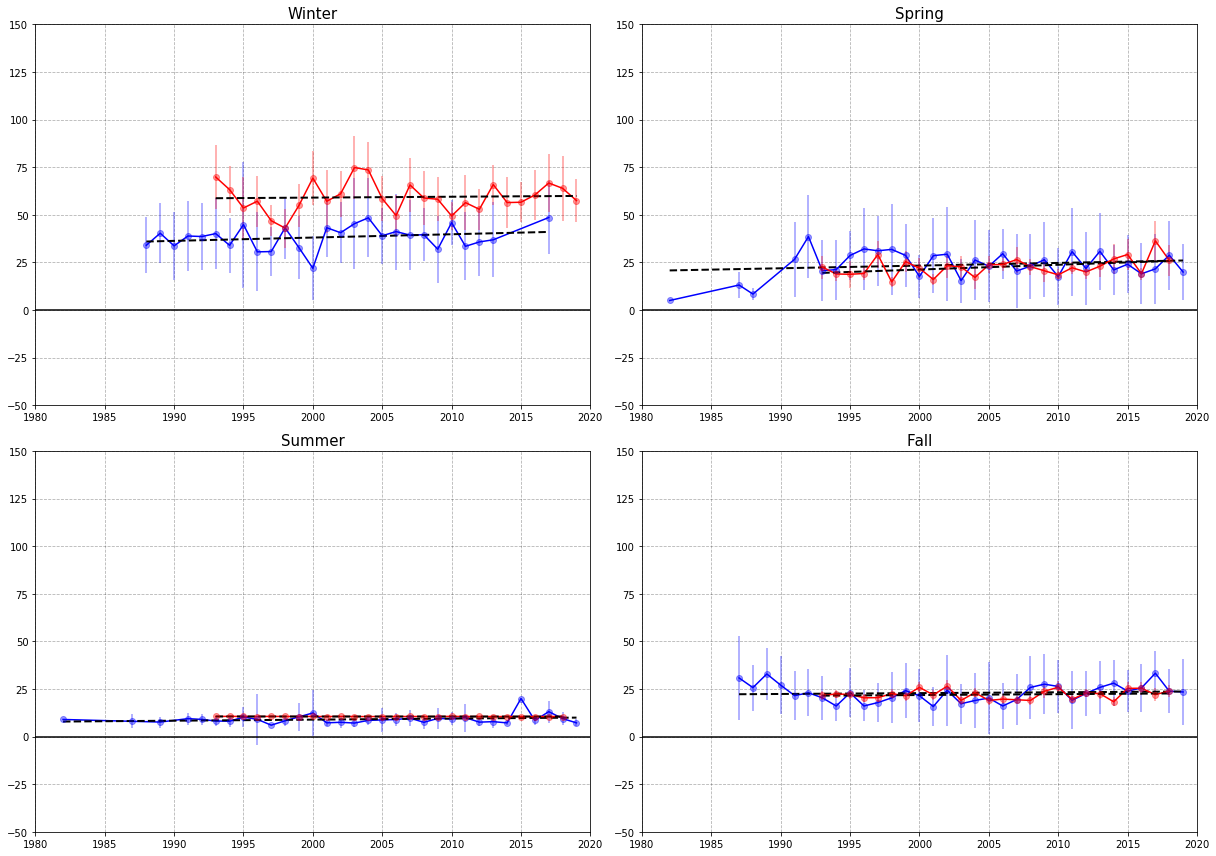

In [851]:
# Eastern GoM
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(17,12))

# winter
winter_mean = [69.84296, 63.21864, 53.576622, 57.144676, 46.89673, 43.018883, 54.938457, 69.281944, 57.10536, 61.02901, 74.82897, 73.54988, 58.497498, 49.587315, 65.68672, 58.829464, 58.16361, 49.398014, 56.400593, 52.88323, 65.880295, 56.42779, 56.598885, 60.41635, 66.69943, 63.90192, 57.475647]
winter_std = [16.666883, 12.312315, 16.353022, 13.334975, 8.240325, 10.2294855, 11.417693, 14.374917, 16.642996, 11.927784, 16.519014, 14.723171, 11.806565, 10.604153, 13.998396, 14.339996, 11.556932, 7.4145694, 14.283459, 10.73429, 10.505907, 13.598846, 10.570808, 13.295955, 14.995041, 17.144146, 11.204289]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
ax1.grid(True)
ax1.axhline(y=0, color='black', linestyle='-')
ax1.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax1.plot(winter_year_NEFSC, winter_mean_NEFSC, color='blue')
ax1.errorbar(winter_year_NEFSC, winter_mean_NEFSC, winter_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax1.plot(np.unique(winter_year_NEFSC), np.poly1d(np.polyfit(winter_year_NEFSC, winter_mean_NEFSC, 1))(np.unique(winter_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')
ax1.plot(years, winter_mean, color='red')
ax1.errorbar(years, winter_mean, winter_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax1.plot(np.unique(years), np.poly1d(np.polyfit(years, winter_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax1.set_title('Winter',fontsize = 15)

# spring
spring_mean = [22.567114, 18.913176, 18.764471, 19.165308, 29.113565, 14.747943, 25.429754, 21.93917, 16.017096, 23.260954, 22.65577, 17.083418, 23.785368, 23.897976, 26.469152, 22.738518, 20.615736, 18.465754, 22.181524, 20.003044, 22.982174, 26.837084, 29.14387, 19.05772, 36.336433, 26.108059]
spring_std = [6.036619, 3.781576, 7.208805, 3.540857, 6.963559, 2.6641815, 5.6733646, 5.212365, 2.7092028, 6.260203, 5.9608006, 6.0090017, 4.466255, 3.5413916, 6.8464513, 4.1565237, 5.963527, 2.8520381, 3.2418656, 3.5849235, 5.695122, 8.029004, 8.271338, 3.1549542, 10.354675, 8.110586]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax2.grid(True)
ax2.axhline(y=0, color='black', linestyle='-')
ax2.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax2.plot(spring_year_NEFSC, spring_mean_NEFSC, color='blue')
ax2.errorbar(spring_year_NEFSC, spring_mean_NEFSC, spring_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax2.plot(np.unique(spring_year_NEFSC), np.poly1d(np.polyfit(spring_year_NEFSC, spring_mean_NEFSC, 1))(np.unique(spring_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax2.plot(years, spring_mean, color='red')
ax2.errorbar(years, spring_mean, spring_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax2.plot(np.unique(years), np.poly1d(np.polyfit(years, spring_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax2.set_title('Spring',fontsize = 15)

# summer
summer_mean = [10.557171, 10.63424, 10.574132, 10.537667, 10.610738, 10.571807, 10.547891, 10.595048, 10.531682, 10.601068, 10.536478, 10.528733, 10.528156, 10.528228, 10.571844, 10.528971, 10.53265, 10.628394, 10.540097, 10.559637, 10.529024, 10.537056, 10.532693, 10.537149, 10.549033, 10.534485]
summer_std = [0.05994575, 0.11196062, 0.078126624, 0.041703533, 0.11625248, 0.065425865, 0.04297835, 0.08599193, 0.038926903, 0.091127716, 0.04327904, 0.038136315, 0.03805744, 0.037953004, 0.08020722, 0.037850723, 0.03756523, 0.09558046, 0.040501516, 0.054111354, 0.038382214, 0.04482719, 0.03870042, 0.04445958, 0.046098147, 0.043720137]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax3.grid(True)
ax3.axhline(y=0, color='black', linestyle='-')
ax3.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax3.plot(summer_year_NEFSC, summer_mean_NEFSC, color='blue')
ax3.errorbar(summer_year_NEFSC, summer_mean_NEFSC, summer_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax3.plot(np.unique(summer_year_NEFSC), np.poly1d(np.polyfit(summer_year_NEFSC, summer_mean_NEFSC, 1))(np.unique(summer_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax3.plot(years, summer_mean, color='red')
ax3.errorbar(years, summer_mean, summer_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax3.plot(np.unique(years), np.poly1d(np.polyfit(years, summer_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax3.set_title('Summer',fontsize = 15)

# autumn
fall_mean = [21.597424, 22.389051, 22.12987, 20.370592, 20.46043, 22.522831, 21.482239, 25.863453, 21.895205, 26.473404, 19.01525, 23.104399, 18.995882, 19.6898, 19.348469, 18.977125, 23.828, 25.897291, 19.565905, 22.847889, 22.575975, 18.30427, 25.332966, 25.407742, 22.041843, 23.946249]
fall_std = [2.5731556, 1.9978379, 2.463038, 1.9683537, 3.0533066, 2.6294174, 2.746695, 2.5534017, 2.6579697, 3.1549578, 2.4216678, 2.412844, 2.18397, 2.6283436, 1.7661653, 2.4021204, 3.790321, 3.1477122, 2.0235498, 2.1342049, 2.6002736, 2.3049088, 3.4741054, 3.456912, 3.2325478, 3.3617315]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax4.grid(True)
ax4.axhline(y=0, color='black', linestyle='-')
ax4.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)
ax4.plot(fall_year_NEFSC, fall_mean_NEFSC, color='blue')
ax4.errorbar(fall_year_NEFSC, fall_mean_NEFSC, fall_std_NEFSC,linestyle='None', marker='o',color='blue',alpha= 0.4)
ax4.plot(np.unique(fall_year_NEFSC), np.poly1d(np.polyfit(fall_year_NEFSC, fall_mean_NEFSC, 1))(np.unique(fall_year_NEFSC)),c='black',linewidth = 2,linestyle = '--')

ax4.plot(years, fall_mean, color='red')
ax4.errorbar(years, fall_mean, fall_std,linestyle='None', marker='o',color='red',alpha= 0.4)
ax4.plot(np.unique(years), np.poly1d(np.polyfit(years, fall_mean, 1))(np.unique(years)),c='black',linewidth = 2,linestyle = '--')
ax4.set_title('Fall',fontsize = 15)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim((-50,150))
    ax.set_xlim((1980,2020))

plt.savefig('Southern Mid-Atlantic Bight')
    
plt.tight_layout()

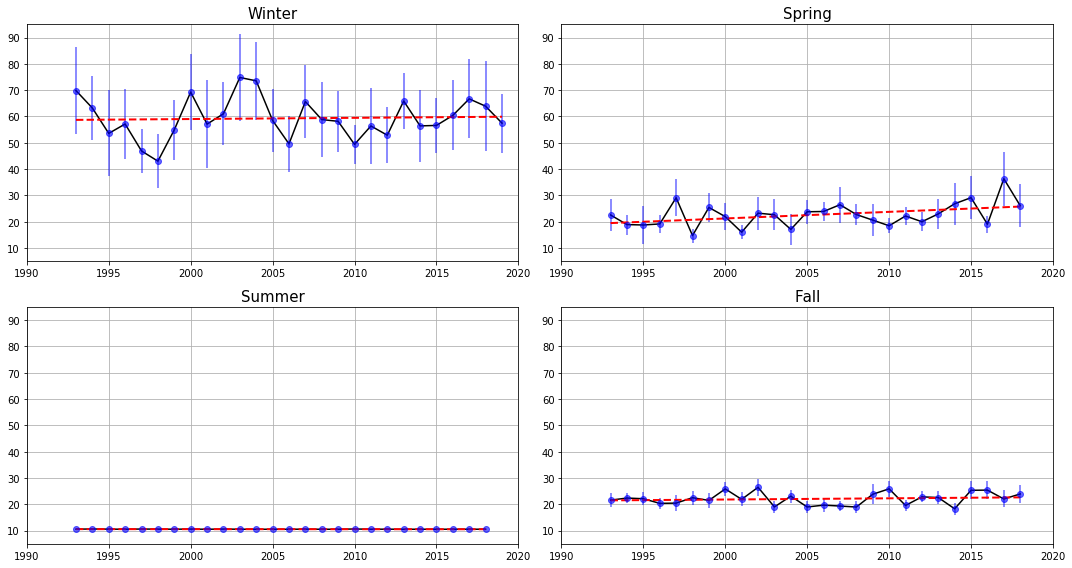

In [171]:
# Western Gulf of Maine
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

# winter
winter_mean = [69.84296, 63.21864, 53.576622, 57.144676, 46.89673, 43.018883, 54.938457, 69.281944, 57.10536, 61.02901, 74.82897, 73.54988, 58.497498, 49.587315, 65.68672, 58.829464, 58.16361, 49.398014, 56.400593, 52.88323, 65.880295, 56.42779, 56.598885, 60.41635, 66.69943, 63.90192, 57.475647]
winter_std = [16.666883, 12.312315, 16.353022, 13.334975, 8.240325, 10.2294855, 11.417693, 14.374917, 16.642996, 11.927784, 16.519014, 14.723171, 11.806565, 10.604153, 13.998396, 14.339996, 11.556932, 7.4145694, 14.283459, 10.73429, 10.505907, 13.598846, 10.570808, 13.295955, 14.995041, 17.144146, 11.204289]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
ax1.grid(True)
ax1.plot(years, winter_mean, color='k')
ax1.errorbar(years, winter_mean, winter_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax1.plot(np.unique(years), np.poly1d(np.polyfit(years, winter_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax1.set_title('Winter',fontsize = 15)

# spring
spring_mean = [22.567114, 18.913176, 18.764471, 19.165308, 29.113565, 14.747943, 25.429754, 21.93917, 16.017096, 23.260954, 22.65577, 17.083418, 23.785368, 23.897976, 26.469152, 22.738518, 20.615736, 18.465754, 22.181524, 20.003044, 22.982174, 26.837084, 29.14387, 19.05772, 36.336433, 26.108059]
spring_std = [6.036619, 3.781576, 7.208805, 3.540857, 6.963559, 2.6641815, 5.6733646, 5.212365, 2.7092028, 6.260203, 5.9608006, 6.0090017, 4.466255, 3.5413916, 6.8464513, 4.1565237, 5.963527, 2.8520381, 3.2418656, 3.5849235, 5.695122, 8.029004, 8.271338, 3.1549542, 10.354675, 8.110586]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax2.grid(True)
ax2.plot(years, spring_mean, color='k')
ax2.errorbar(years, spring_mean, spring_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax2.plot(np.unique(years), np.poly1d(np.polyfit(years, spring_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax2.set_title('Spring',fontsize = 15)

# summer
summer_mean = [10.557171, 10.63424, 10.574132, 10.537667, 10.610738, 10.571807, 10.547891, 10.595048, 10.531682, 10.601068, 10.536478, 10.528733, 10.528156, 10.528228, 10.571844, 10.528971, 10.53265, 10.628394, 10.540097, 10.559637, 10.529024, 10.537056, 10.532693, 10.537149, 10.549033, 10.534485]
summer_std = [0.05994575, 0.11196062, 0.078126624, 0.041703533, 0.11625248, 0.065425865, 0.04297835, 0.08599193, 0.038926903, 0.091127716, 0.04327904, 0.038136315, 0.03805744, 0.037953004, 0.08020722, 0.037850723, 0.03756523, 0.09558046, 0.040501516, 0.054111354, 0.038382214, 0.04482719, 0.03870042, 0.04445958, 0.046098147, 0.043720137]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax3.grid(True)
ax3.plot(years, summer_mean, color='k')
ax3.errorbar(years, summer_mean, summer_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax3.plot(np.unique(years), np.poly1d(np.polyfit(years, summer_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax3.set_title('Summer',fontsize = 15)

# autumn
fall_mean = [21.597424, 22.389051, 22.12987, 20.370592, 20.46043, 22.522831, 21.482239, 25.863453, 21.895205, 26.473404, 19.01525, 23.104399, 18.995882, 19.6898, 19.348469, 18.977125, 23.828, 25.897291, 19.565905, 22.847889, 22.575975, 18.30427, 25.332966, 25.407742, 22.041843, 23.946249]
fall_std = [2.5731556, 1.9978379, 2.463038, 1.9683537, 3.0533066, 2.6294174, 2.746695, 2.5534017, 2.6579697, 3.1549578, 2.4216678, 2.412844, 2.18397, 2.6283436, 1.7661653, 2.4021204, 3.790321, 3.1477122, 2.0235498, 2.1342049, 2.6002736, 2.3049088, 3.4741054, 3.456912, 3.2325478, 3.3617315]
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ax4.grid(True)
ax4.plot(years, fall_mean, color='k')
ax4.errorbar(years, fall_mean, fall_std,linestyle='None', marker='o',color='blue',alpha= 0.6)
ax4.plot(np.unique(years), np.poly1d(np.polyfit(years, fall_mean, 1))(np.unique(years)),c='red',linewidth = 2,linestyle = '--')
ax4.set_title('Fall',fontsize = 15)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim((5,95))
    ax.set_xlim((1990,2020))

plt.savefig('WesternGoM')
    
plt.tight_layout()

In [854]:
import matplotlib.pyplot as plt; from scipy import stats

# winter
y = [69.84296, 63.21864, 53.576622, 57.144676, 46.89673, 43.018883, 54.938457, 69.281944, 57.10536, 61.02901, 74.82897, 73.54988, 58.497498, 49.587315, 65.68672, 58.829464, 58.16361, 49.398014, 56.400593, 52.88323, 65.880295, 56.42779, 56.598885, 60.41635, 66.69943, 63.90192, 57.475647]
x = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

# spring
y = [22.567114, 18.913176, 18.764471, 19.165308, 29.113565, 14.747943, 25.429754, 21.93917, 16.017096, 23.260954, 22.65577, 17.083418, 23.785368, 23.897976, 26.469152, 22.738518, 20.615736, 18.465754, 22.181524, 20.003044, 22.982174, 26.837084, 29.14387, 19.05772, 36.336433, 26.108059]
x = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

# summer
y = [10.557171, 10.63424, 10.574132, 10.537667, 10.610738, 10.571807, 10.547891, 10.595048, 10.531682, 10.601068, 10.536478, 10.528733, 10.528156, 10.528228, 10.571844, 10.528971, 10.53265, 10.628394, 10.540097, 10.559637, 10.529024, 10.537056, 10.532693, 10.537149, 10.549033, 10.534485]
x = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)
print('')

# fall
y = [21.597424, 22.389051, 22.12987, 20.370592, 20.46043, 22.522831, 21.482239, 25.863453, 21.895205, 26.473404, 19.01525, 23.104399, 18.995882, 19.6898, 19.348469, 18.977125, 23.828, 25.897291, 19.565905, 22.847889, 22.575975, 18.30427, 25.332966, 25.407742, 22.041843, 23.946249]
x = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    pvalue: %f" % (slope, p_value))
print("R-squared: %f" % r_value**2)

slope: 0.045780    pvalue: 0.817288
R-squared: 0.002176

slope: 0.250990    pvalue: 0.037357
R-squared: 0.168336

slope: -0.001799    pvalue: 0.031335
R-squared: 0.178892

slope: 0.045543    pvalue: 0.483882
R-squared: 0.020634


In [856]:
import matplotlib.pyplot as plt; from scipy import stats

# winter
y = winter_mean_NEFSC
x = winter_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# spring
y = spring_mean_NEFSC
x = spring_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# summer
y = summer_mean_NEFSC
x = summer_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)
print('')

# fall
y = fall_mean_NEFSC
x = fall_year_NEFSC
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f" % (slope))
print("p_value: %f" % p_value)
print("R-squared: %f" % r_value**2)

slope: 0.173634
p_value: 0.247401
R-squared: 0.053129

slope: 0.140880
p_value: 0.286999
R-squared: 0.037692

slope: 0.055790
p_value: 0.219855
R-squared: 0.049737

slope: 0.044563
p_value: 0.609950
R-squared: 0.008495


In [859]:
from scipy.stats.stats import pearsonr   

print (pearsonr(winter_mean,winter_mean_NEFSC))

(-0.04959710548528614, 0.8059373987530187)


In [895]:
x = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,2019]
print(x)

[1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [896]:
print(winter_year_NEFSC)

[1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2017]


In [899]:
print(winter_mean_NEFSC)
print(len(winter_mean_NEFSC))

workable = [40.12931034482759, 33.95652173913044, 44.851063829787236, 30.53846153846154, 30.694444444444443, 43.15151515151515, 32.72222222222222, 21.92105263157895, 43.21951219512195, 40.59183673469388, 45.333333333333336, 48.425, 39.0, 41.19047619047619, 39.30555555555556, 39.54545454545455, 31.9375, 45.88235294117647, 33.44230769230769, 35.75, 36.875, 48.56521739130435]
print(len(workable))

[34.0, 40.333333333333336, 33.68539325842696, 38.86363636363637, 38.59, 40.12931034482759, 33.95652173913044, 44.851063829787236, 30.53846153846154, 30.694444444444443, 43.15151515151515, 32.72222222222222, 21.92105263157895, 43.21951219512195, 40.59183673469388, 45.333333333333336, 48.425, 39.0, 41.19047619047619, 39.30555555555556, 39.54545454545455, 31.9375, 45.88235294117647, 33.44230769230769, 35.75, 36.875, 48.56521739130435]
27
22


In [900]:
print(winter_mean)

[69.84296, 63.21864, 53.576622, 57.144676, 46.89673, 43.018883, 54.938457, 69.281944, 57.10536, 61.02901, 74.82897, 73.54988, 58.497498, 49.587315, 65.68672, 58.829464, 58.16361, 49.398014, 56.400593, 52.88323, 65.880295, 56.42779, 56.598885, 60.41635, 66.69943, 63.90192, 57.475647]


In [901]:
winter_new = [69.84296, 63.21864, 53.576622, 57.144676, 46.89673, 43.018883, 54.938457, 69.281944, 57.10536, 61.02901, 74.82897, 73.54988, 58.497498, 49.587315, 65.68672, 58.829464, 58.16361, 49.398014, 56.400593, 52.88323, 65.880295, 66.69943]

In [902]:
print(len(winter_new))

22


In [903]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(workable, winter_new))

In [904]:
print(rms)

23.20222017754077


### Seasonal Cycle by Region

In [724]:
wmean_lat = weighted_mean(data_1993_2018.mlotst, dim='latitude', weights=weights_lat)
wmean =  wmean_lat.mean(dim='longitude')
annual_wmean = wmean.groupby('time.year').mean(dim='time')

In [725]:
# polygon_y <- eastern gulf of maine
y_mean = [46.69268180349063, 51.913679744003275, 47.13657596371882, 39.99121714463323, 26.70990733552653, 19.345167398488726, 7.951340920983778, 9.047521506632343, 15.248328624464735, 29.628786721058084, 48.27589840759273, 60.50918367346939]
y_mean_std = [24.827231050417865, 24.260579344026585, 24.488714227859422, 29.25794819598738, 27.954188754858613, 30.012383119020267, 1.992531578828787, 4.008072062214131, 10.476912259086825, 14.277263822611843, 21.78207683823901, 24.66850879711285]
# polygon_t <- western gulf of maine
t_mean = [85.04992993827163, 78.90637648280651, 61.98153853109096, 42.75433992751779, 21.73314355793488, 10.737171415773837, 7.474173856534484, 8.546309589013935, 14.547464386622254, 26.67980550839848, 42.25205271863326, 61.92922619047619]
t_mean_std = [36.41732070692535, 36.49457650177204, 32.247754462080266, 43.20901952895481, 28.35462515028076, 6.220705288621097, 1.6820483402013944, 3.29859188795832, 4.490487747274347, 12.488033420815079, 19.849750238498384, 19.42800966583414]
# polygon_w <- georges bank
w_mean = [46.86857432038734, 44.77320257019368, 47.835552512998554, 40.048661193286975, 26.844363944682343, 22.35953679122353, 11.840849633319301, 14.843668404611881, 19.302954291600276, 28.414081900368664, 39.878264743424005, 46.46725121289325]
w_mean_std = [18.022963858680264, 17.73849834899739, 19.94849022588707, 21.2576412074335, 20.927194433135405, 19.49361727697807, 8.066058215787795, 13.187197121207907, 13.034721419237089, 15.950578260254357, 17.803509277244846, 16.80495584633565]
# polygon_v <- southern mab
v_mean = [39.4447792106883, 35.23147378330791, 26.443160090009297, 31.521850470254726, 10.68343376867634, 7.5709949250561115, 8.070459121339379, 9.062005229136329, 13.281902429992464, 22.121793494725825, 26.251677959381496] # missing dec
v_mean_std = [21.011660159499485, 24.865452803222144, 23.55984942304523, 18.515218239020847, 8.31496841090125, 2.2628611207687457, 1.8485174833742801, 3.162163260891883, 5.989795823027838, 7.571068852896732, 12.940193765871559] # missing dec
# polygon_x <- northern mab
x_mean = [40.20740960724103, 38.88971875128138, 26.82489962695401, 31.295208359759904, 11.215743411816572, 10.775280037841787, 7.7757026927221435, 8.775792670945748, 15.886193623579935, 25.694375596873833, 34.337803110468535, 36.576357766337026]
x_mean_std = [14.517855270098709, 18.66455516517325, 16.89007292526143, 13.226886898654998, 6.498256896120208, 5.367801855113718, 1.659154426472171, 3.2965217239847218, 6.650119993975526, 11.385235428191773, 15.585845594667076, 13.120425335528545]

In [726]:
full = data_1993_2018.mlotst
full_month = full.groupby('time.month').mean(dim='time')

In [347]:
mean = []; std = []
for i in range(12):
    wmean = full_month
    useable = wmean[i]
    useabletransp = useable.transpose()
    
    newlon = lonlist_t #newlon 
    newlat = latlist_t #newlat 
    newpath = list(zip(newlon,newlat))
    newpd = pd.DataFrame(newpath, columns=['lon','lat'])
    path_new = Path(newpath)
    points = np.vstack((loncheck,latcheck)).T
    path_new = Path(newpath)
        
    grid = path_new.contains_points(points)
    grid = grid.reshape((181,133))
    
    newgridded = np.where(grid == False, np.nan, useabletransp)
    
    mean.append(np.nanmean(newgridded))
    std.append(np.nanstd(newgridded))

In [723]:
# print(mean); print(std)

In [350]:
month = [1,2,3,4,5,6,7,8,9,10,11,12]

In [729]:
month_short = [1,2,3,4,5,6,7,8,9,10,11]

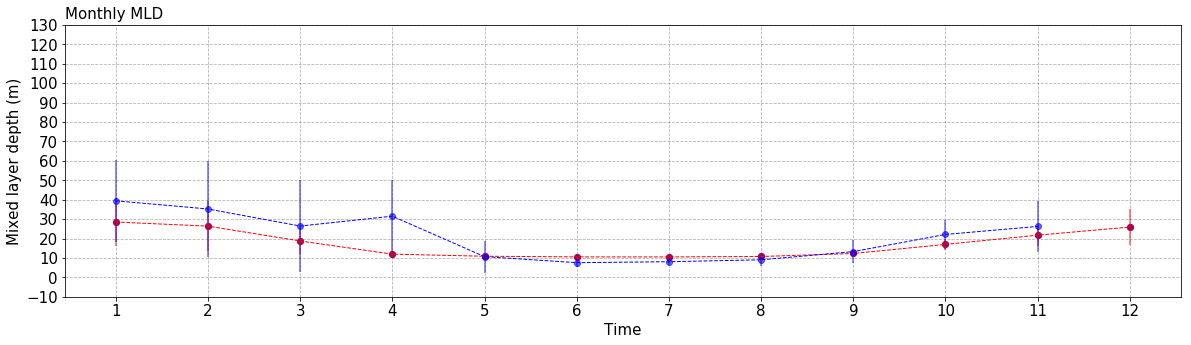

In [750]:
plt.figure(figsize=(20,5))
plt.ylim(-10,130)
plt.scatter(month, mean_smab, marker='o', c='blue')
plt.plot(month, mean_smab, linestyle='--', color='red', linewidth=1)
plt.errorbar(month,mean_smab, std_smab,linestyle='None', marker='o',color='red',alpha= 0.6)
plt.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.3)


plt.plot(month_short, v_mean, linestyle='--', color='blue', linewidth=1)
plt.errorbar(month_short,v_mean, v_mean_std,linestyle='None', marker='o',color='blue',alpha= 0.6)

plt.xlabel('Time', fontsize = 15)
plt.ylabel('Mixed layer depth (m)', fontsize = 15)
plt.title('Monthly MLD', loc='left',fontsize = 15)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], fontsize = 15) 
plt.yticks([-10,0,10,20,30,40,50,60,70,80,90,100,110,120,130], fontsize = 15) 
# plt.grid(True)
plt.savefig('seasonal')
plt.show()

In [362]:
# from Glorys reanalysis dataset
mean_smab = [28.52312, 26.398628, 18.762217, 11.969404, 10.894996, 10.556597, 10.539083, 10.761103, 12.310016, 16.998425, 21.743761, 25.917747]
std_smab = [12.594098, 12.788414, 6.6326094, 1.2710886, 0.6135138, 0.39856482, 0.40000543, 0.5094891, 1.1338102, 2.926082, 5.4170194, 9.316063]

mean_nmab = [35.444305, 30.052769, 22.473381, 13.2093, 11.065268, 10.569111, 10.505562, 10.61649, 12.550364, 19.285315, 26.95002, 33.752716]
std_nmab = [10.234419, 9.284063, 6.5911775, 2.7600367, 1.1512449, 0.33943844, 0.29805484, 0.3347096, 1.285651, 3.5426762, 5.0451717, 8.116086]

mean_gb = [43.74954, 40.346222, 31.882727, 18.899754, 12.043853, 10.756371, 10.548233, 10.763683, 13.532605, 23.389027, 35.10641, 42.88207]
std_gb = [9.3763895, 9.42878, 7.079966, 4.7500577, 1.7822286, 0.26354071, 0.040794127, 0.33271286, 1.7562642, 3.2199059, 5.9148893, 8.545876]

mean_egom = [44.559803, 36.530952, 27.16033, 16.418987, 11.555608, 10.656844, 10.538515, 10.589611, 11.884604, 19.899092, 33.57842, 43.575108]
std_egom = [10.881172, 9.287496, 4.897979, 1.6053677, 0.24999952, 0.03598088, 0.010185858, 0.038287934, 0.38035426, 1.8444589, 5.0097494, 8.295651]

mean_wgom = [63.818626, 62.464752, 40.3597, 16.213873, 11.098084, 10.580502, 10.530079, 10.559026, 11.7398615, 19.530334, 35.052883, 51.62398]
std_wgom = [10.925984, 13.153418, 9.229162, 2.4261792, 0.41584638, 0.059860904, 0.03792746, 0.046751317, 0.550964, 1.9502542, 3.855986, 6.8574543]

### Spatial Plots

In [1036]:
useable = wmean_DJF['mlotst']
print(useable.shape)
print(type(useable))
print(useable[26])

(27, 133, 181)
<class 'xarray.core.dataarray.DataArray'>
<xarray.DataArray 'mlotst' (latitude: 133, longitude: 181)>
array([[       nan,        nan,        nan, ...,  97.53105 ,  98.605316,
         99.14244 ],
       [       nan,        nan,        nan, ...,  97.81792 ,  99.9298  ,
        100.65614 ],
       [       nan,        nan,        nan, ...,  99.533066,  99.53917 ,
        100.56459 ],
       ...,
       [       nan,        nan,        nan, ...,  13.367109,  13.318277,
         18.768885],
       [       nan,        nan,        nan, ...,  22.046572,  24.268322,
         22.040468],
       [       nan,        nan,        nan, ...,  18.372145,  17.120886,
         11.700797]], dtype=float32)
Coordinates:
    time       datetime64[ns] 2019-02-28
  * latitude   (latitude) float32 35.0 35.083332 35.166668 ... 45.916668 46.0
  * longitude  (longitude) float32 -78.0 -77.916664 ... -63.083332 -63.0


In [1037]:
print(np.mean(useable[23]))
print(type(useable[23]))
print(useable[23].shape)

<xarray.DataArray 'mlotst' ()>
array(59.916924, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-02-29
<class 'xarray.core.dataarray.DataArray'>
(133, 181)


In [1038]:
useable23transp = useable[23].transpose()

In [1039]:
print(useable23transp.shape)

(181, 133)


In [1040]:
print(np.std(useable[0]))

<xarray.DataArray 'mlotst' ()>
array(36.28998947)
Coordinates:
    time     datetime64[ns] 1993-02-28


In [428]:
newgridded = np.where(grid == False, np.nan, useable23transp)

In [429]:
print(newgridded)

[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [110.49379  111.74976  113.65631  ...  12.594753  19.588865  16.820398]
 [110.44181  112.106895 114.11743  ...  12.406947  20.732473  15.562766]
 [110.7889   112.0952   113.664696 ...  16.344173  18.576054  10.966543]]


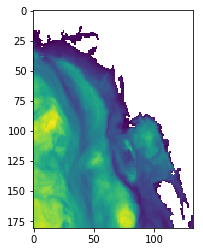

In [430]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(newgridded)

In [1024]:
print(np.nanmean(newgridded))
print(np.nanstd(newgridded))

20.616787
3.6732552


In [405]:
wmean_lat = weighted_mean(data_1993_2018.mlotst, dim='latitude', weights=weights_lat)
wmean =  wmean_lat.mean(dim='longitude')
annual_wmean = wmean.groupby('time.year').mean(dim='time')

/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [1041]:
wmean_DJF_mld_mean=wmean_DJF.mlotst.mean(dim='time')
wmean_DJF_mld_mean_tranpose = wmean_DJF_mld_mean.transpose()
print(wmean_DJF_mld_mean_tranpose.shape)

(181, 133)


/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [550]:
wmean_DJF_mld_std=wmean_DJF.mlotst.std(dim='time')
wmean_DJF_mld_std_tranpose = wmean_DJF_mld_std.transpose()
print(wmean_DJF_mld_std_tranpose.shape)

(181, 133)


In [593]:
print(wmean_DJF['mlotst'].shape)
wmean_DJF_mld_mean=wmean_DJF.mlotst.mean(dim='time')
print(wmean_DJF_mld_mean.shape)

(27, 133, 181)
(133, 181)


/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [1067]:
wmean_MAM_mld_mean=wmean_MAM.mlotst.mean(dim='time')
wmean_MAM_mld_mean_tranpose = wmean_MAM_mld_mean.transpose()
print(wmean_MAM_mld_mean_tranpose.shape)

(181, 133)


/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [532]:
wmean_MAM_mld_std=wmean_MAM.mlotst.std(dim='time')
wmean_MAM_mld_std_tranpose = wmean_MAM_mld_std.transpose()
print(wmean_MAM_mld_std_tranpose.shape)

(181, 133)


In [1087]:
wmean_JJA_mld_mean=wmean_JJA.mlotst.mean(dim='time')
wmean_JJA_mld_mean_tranpose = wmean_JJA_mld_mean.transpose()
print(wmean_JJA_mld_mean_tranpose.shape)

(181, 133)


/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [509]:
wmean_JJA_mld_std=wmean_JJA.mlotst.std(dim='time')
wmean_JJA_mld_std_tranpose = wmean_JJA_mld_std.transpose()
print(wmean_JJA_mld_std_tranpose.shape)

(181, 133)


In [1108]:
wmean_SON_mld_mean=wmean_SON.mlotst.mean(dim='time')
wmean_SON_mld_mean_tranpose = wmean_SON_mld_mean.transpose()
print(wmean_SON_mld_mean_tranpose.shape)

(181, 133)


/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [478]:
wmean_SON_mld_std=wmean_SON.mlotst.std(dim='time')
wmean_SON_mld_std_tranpose = wmean_SON_mld_std.transpose()
print(wmean_SON_mld_std_tranpose.shape)

(181, 133)


In [1109]:
newgridded = np.where(grid == False, np.nan, wmean_SON_mld_mean_tranpose)

In [1110]:
print(newgridded)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


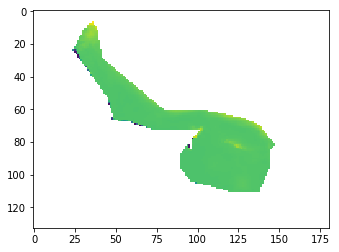

In [1111]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(newgriddedtransp)

In [1112]:
print(newgridded.shape)

(181, 133)


In [1113]:
print(DS_lat.shape)

(133,)


In [1114]:
newgriddedtransp = newgridded.transpose()

In [1115]:
print(np.nanmax(newgriddedtransp))

32.593082


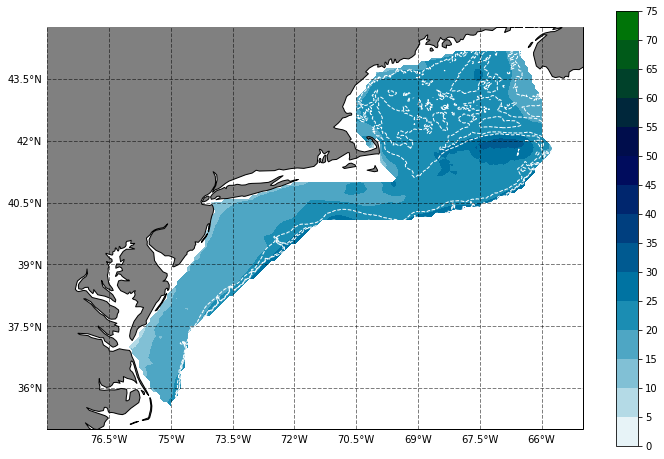

In [1116]:
from matplotlib.pyplot import * ; import cartopy.feature as cfeature

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-78, -65, 35, 44.75], ccrs.PlateCarree())
# feature = cfeature.NaturalEarthFeature(name='coastline', category='physical',scale='50m',edgecolor='black', facecolor='grey')
# ax.add_feature(feature)
cbarticks = np.arange(0,80, 5)
cf=ax.contourf(DS_lon, DS_lat, newgriddedtransp, np.arange(0, 80,5), transform=data_crs,cmap = 'ocean_r')
cbar = plt.colorbar(cf, ax=ax, ticks = cbarticks)

ax.contour(lonNC, latNC, depthNC, [-300,-200,-100], linewidths=1,colors='white',zorder=5)

feature = cfeature.NaturalEarthFeature(name='coastline', category='physical',scale='50m',edgecolor='black', facecolor='grey')
ax.add_feature(feature,zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=0.5, linestyle='--',zorder = 40)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# plot(x_w,y_w,color='red', linewidth = 2, linestyle='-',zorder=10) #Georges Bank
# plot(x_v,y_v,color='red', linewidth = 2, linestyle='-',zorder=10) #Southern MAB
# plot(x_x,y_x,color='red', linewidth = 2, linestyle='-',zorder=10) #Northern MAB
# plot(x_y,y_y,color='red', linewidth = 2, linestyle='-',zorder=10) #Eastern GoM
# plot(x_t,y_t,color='red', linewidth = 2, linestyle='-',zorder=10) #Western GoM

plt.savefig('regiondisplay')
plt.show()

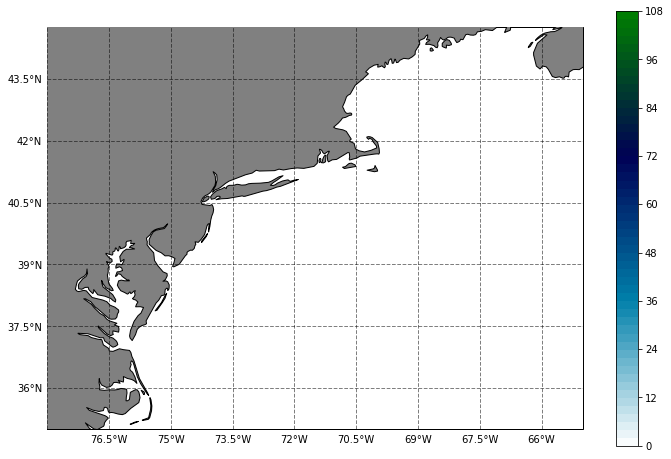

In [1008]:
from matplotlib.pyplot import * ; import cartopy.feature as cfeature

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-78, -65, 35, 44.75], ccrs.PlateCarree())

feature = cfeature.NaturalEarthFeature(name='coastline', category='physical',scale='50m',edgecolor='black', facecolor='grey')
ax.add_feature(feature,zorder=5)
cf=ax.contourf(DS_lon, DS_lat, newgriddedtransp,np.arange(0, 110,2),cmap = 'ocean_r')

# cf=ax.contourf(DS_lon, DS_lat, newgriddedtransp,np.arange(0, 110,2),cmap = 'ocean_r')
# cf=ax.contourf(DS_lon, DS_lat, newgriddedtransp,np.arange(0,33,1),cmap = 'ocean_r')
# ax.contour(DS_lon, DS_lat, newgriddedtransp, levels=9, linewidths=1,colors='white',zorder=5,)
# ax.contour(lonNC, latNC, depthNC, [-300,-250,-200,-150,-100,-50], linewidths=1,colors='black',zorder=5)
# ax.contour(DS_lon, DS_lat, newgriddedtransp, levels=55, linewidths=1,colors='black',zorder=5,) # Summer mean
plt.colorbar(cf)
# plot(newlon,newlat,color='black') 
# ax.set_label(DS.mlotst.units)
# plt.title("Average Winter Mixed Layer Depth (m) from 1993 to 2018")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=0.5, linestyle='--', zorder = 20)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.savefig('glorys.png')
plt.show()

In [1016]:
print(np.nanmax(newgriddedtransp))

32.593082


In [988]:
file_in ='Etopo1_Bed_35_65N_40_80W.nc'
NC=Dataset(file_in); DS=xr.open_dataset(file_in)

projection= ccrs.PlateCarree(central_longitude=255);
data_crs = ccrs.PlateCarree()

In [989]:
latNC= NC['lat'][:]
lonNC= NC['lon'][:]
depthNC= NC['depth'][:]

In [ ]:
# NEFSC dataset
# winter
winter_mean_NEFSC = 
winter_std_NEFSC = 
winter_year_NEFSC = 
winter_ratiomean_NEFSC = 
winter_ratiostd_NEFSC = 

# spring
spring_mean_NEFSC = 
spring_std_NEFSC = 
spring_year_NEFSC = 
spring_ratiomean_NEFSC = 
spring_ratiostd_NEFSC = 

# summer
summer_mean_NEFSC = 
summer_std_NEFSC = 
summer_year_NEFSC = 
summer_ratiomean_NEFSC = 
summer_ratiostd_NEFSC = 

# fall
fall_mean_NEFSC = 
fall_std_NEFSC = 
fall_year_NEFSC = 
fall_ratiomean_NEFSC = 
fall_ratiostd_NEFSC = 